In [1]:
#!pip3 install accelerate transformers[pytorch] PyTorch optuna wandb datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import optuna 
from optuna import trial
import random
import os 
import pickle

import torch.cuda
import torch
from torch import nn

import wandb
wandb.login()

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import TrainerCallback
from transformers import set_seed

from sklearn.metrics import (accuracy_score,
                            f1_score,
                            precision_score,
                            recall_score,
                            precision_recall_curve,
                            auc, 
                            confusion_matrix,
                            ConfusionMatrixDisplay,
                            balanced_accuracy_score,
                            classification_report)

from sklearn.model_selection import train_test_split

from datasets import Dataset, DatasetDict
from accelerate import Accelerator
from numpy.random import seed
from lightning.pytorch import seed_everything
import time

/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: joelyacob91 (master-2024). Use `wandb login --relogin` to force relogin
2024-04-18 00:04:14.255871: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model_ckpt = "bert-large-uncased"

In [4]:
def model_init():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=3)
    model.to(device)
    return model

In [5]:
model_init()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,

In [6]:
!nvidia-smi

Thu Apr 18 00:05:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                On  | 00000000:01:00.0 Off |                  Off |
| 33%   38C    P2              75W / 260W |   1455MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
print(torch.cuda.device_count())

1


In [8]:
print(os.getcwd())

/net/fs-2/scale/OrionStore/Home/joteklem/Pytorch_models


In [9]:
with open('/net/fs-2/scale/OrionStore/Home/joteklem/Preprocessing/BERT_dataset_15.pkl', 'rb') as f:
    encoded_dataset_15 = pickle.load(f)
encoded_dataset_15

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10078
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3360
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3360
    })
})

In [10]:
with open('/net/fs-2/scale/OrionStore/Home/joteklem/Preprocessing/BERT_dataset_30.pkl', 'rb') as f:
    encoded_dataset_30 = pickle.load(f)
encoded_dataset_30

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10128
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3376
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3376
    })
})

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [12]:
#class_weights = (1 - (df['encoded_text'].value_counts().sort_index() / len(df))).values
#class_weights

In [13]:
#class_weights = torch.from_numpy(class_weights).float().to('cuda')
#class_weights

In [14]:
#class WeightedLossTrainer(Trainer):
#  def Loss(self, model, input, return_outputs=False):

    # Feed input to model and extract logits
#    outputs = model(**inputs)
#    logits = outputs.get('logits')

    # Extract labels
#    labels = inputs.get('labels')

    # Define loss function with class weights
#    loss_func = nn.CrossEntropyLoss(weight=class_weights)

    # Compute loss
#    loss = loss_func(logits, labels)

#    return (loss, ouputs) if return_outputs else loss

In [15]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(-1)

    # F1-Score
    f1 = f1_score(labels, preds, average="weighted", zero_division=0)
    f1_macro = f1_score(labels, preds, average="macro", zero_division=0)
    f1_micro = f1_score(labels, preds, average="micro", zero_division=0)

    # Precision
    #precision = precision_score(labels, preds, average='weighted')
    #precision_macro = precision_score(labels, preds, average='macro')
    #precision_micro = precision_score(labels, preds, average='micro')

    # Recall
    #recall = recall_score(labels, preds, average='weighted')
    #recall_macro = recall_score(labels, preds, average='macro')
    #recall_micro = recall_score(labels, preds, average='micro')

    # Accuracy
    acc = accuracy_score(labels, preds)
    bal_acc = balanced_accuracy_score(labels, preds)

    # Classification report 
    class_report = classification_report(labels, preds, output_dict=True, zero_division=0)
    
    return {"Accuracy": acc,
            "Balanced accuracy": bal_acc,
            "F1 weighted": f1,
            'F1 macro':f1_macro,
            'F1 micro':f1_micro,
            #'Recall': recall,
            #'Precision': precision,
            "Classification Report": class_report}

In [16]:
class LossTrackingCallback(TrainerCallback):
    """Logs aggregate metrics after each epoch."""
    def __init__(self):
        super().__init__()
        # Initialize lists to store all values temporarily
        self._training_losses = []
        self._validation_losses = []
        # Initialize variables to store final or average values
        self.final_training_loss = None
        self.final_validation_loss = None

    def on_epoch_end(self, args, state, control, **kwargs):
        # Compute final or average losses here and store them in instance variables
        if self._training_losses:
            self.final_training_loss = self._training_losses[-1] 
        if self._validation_losses:
            self.final_validation_loss = self._validation_losses[-1]  

    def on_log(self, args, state, control, logs=None, **kwargs):
        # Temporarily store all loss values
        if 'loss' in logs:
            self._training_losses.append(logs['loss'])
        if 'eval_loss' in logs:
            self._validation_losses.append(logs['eval_loss'])

loss_metric = LossTrackingCallback()

In [17]:
class OptunaCallback(TrainerCallback):
    def __init__(self, trial):
        self.trial = trial

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        # Report the intermediate value to Optuna
        self.trial.report(metrics['eval_F1 weighted'], step=state.epoch)
        # Check if the current trial should be pruned
        if self.trial.should_prune():
            raise optuna.exceptions.TrialPruned()

In [18]:

def objective_closure(data):
    """
    A closure for the objective function to include the dataset.
    """
    def objective(trial):
        
        wandb.init(project='BERT_LARGE', config=trial.params, name=f"trial-{trial.number}")
         
        print(f"Starting trial {trial.number}")
        
        # Hyperparameter suggestions
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
        per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32])
        weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
        num_train_epochs = trial.suggest_categorical('num_train_epochs', [2, 3, 4, 5])
        warmup_steps = trial.suggest_int('warmup_steps', 0, 500)
    
        model_name = f"{model_ckpt}-finetuned-ASR_text"
        
        # Setup training arguments
        training_args = TrainingArguments(
            output_dir=model_name,  
            num_train_epochs=num_train_epochs,
            learning_rate=learning_rate,
            per_device_train_batch_size=per_device_train_batch_size,
            per_device_eval_batch_size=per_device_train_batch_size,
            weight_decay=weight_decay,
            warmup_steps=warmup_steps,
            evaluation_strategy="epoch",
            gradient_accumulation_steps=2,
            fp16=True,
            disable_tqdm=False,
            logging_steps=len(data['train']) // per_device_train_batch_size,
            log_level="error",
            report_to="wandb", 
            seed=23
        )
    
        # Initialize the Trainer
        trainer = Trainer(
            model_init=model_init,
            args=training_args,
            compute_metrics=compute_metrics,
            train_dataset=data['train'],
            eval_dataset=data['validation'],
            callbacks=[OptunaCallback(trial),loss_metric],
            tokenizer=tokenizer,
        )
    
        # Train the model
        trainer.train()
    
        # Evaluate the model
        eval_results = trainer.evaluate()
    
        # Store metrics in user attributes of the trial
        trial.set_user_attr('eval_F1 weighted', eval_results.get('eval_F1 weighted'))
        f1_score_obj_weighted = eval_results.get('eval_F1 weighted')

        trial.set_user_attr('eval_F1 macro', eval_results.get('eval_F1 macro'))
        f1_score_obj_macro = eval_results.get('eval_F1 macro')

        # Check if the current trial is the best
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        print(f"Completed trial {trial.number}")
    
        training_loss = loss_metric.final_training_loss
        validation_loss = loss_metric.final_validation_loss
    
        wandb.log({"Weighted F1 score": f1_score_obj_weighted})
        wandb.log({"Training loss":training_loss, "Validation loss":validation_loss})
            
        wandb.finish()
        
        # Return the primary metric for optimization
        return f1_score_obj_macro
     
    return objective

In [19]:
# Seed
sampler = optuna.samplers.TPESampler(seed=42)

# Enable Optuna's default logging
optuna.logging.enable_default_handler()

# Create the study with a pruner
pruner = optuna.pruners.MedianPruner()

study_15 = optuna.create_study(
    direction="maximize",
    study_name='BERT_LARGE_15_study',
    storage='sqlite:///BERT_LARGE_15.db',
    pruner=pruner, sampler=sampler
)

study_30 = optuna.create_study(
    direction="maximize",
    study_name='BERT_LARGE_30_study',
    storage='sqlite:///BERT_LARGE_30.db',
    pruner=pruner, sampler=sampler
)

[I 2024-04-18 00:05:50,501] A new study created in RDB with name: BERT_LARGE_15_study
[I 2024-04-18 00:05:51,585] A new study created in RDB with name: BERT_LARGE_30_study


In [20]:
# Get the objective function with your dataset included
objective_15 = objective_closure(encoded_dataset_15)

start_study_15 = time.time()
study_15.optimize(objective_15, n_trials=32) #, timeout=600)  
end_study_15 = time.time()

model_time_study_15 = end_study_15 - start_study_15

Starting trial 0


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.879974,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
2,0.818200,0.863963,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
3,0.818200,0.862097,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
4,0.871800,0.860012,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"


Completed trial 0


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▁▁▁▁
eval/Balanced accuracy,▁▁▁▁▁
eval/F1 macro,▁▁▁▁▁
eval/F1 micro,▁▁▁▁▁
eval/F1 weighted,▁▁▁▁▁
eval/loss,█▂▂▁▁
eval/runtime,█▅▁▃▅
eval/samples_per_second,▁▄█▆▄


[I 2024-04-18 00:18:40,186] Trial 0 finished with value: 0.26005929690808977 and parameters: {'learning_rate': 5.6115164153345e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.04680559213273095, 'num_train_epochs': 4, 'warmup_steps': 354}. Best is trial 0 with value: 0.26005929690808977.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 1


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.545708,0.804167,0.669577,0.794118,0.706563,0.804167,"{'0': {'precision': 0.7456492637215528, 'recall': 0.6202672605790646, 'f1-score': 0.6772036474164133, 'support': 898.0}, '1': {'precision': 0.8269310202395704, 'recall': 0.9315960912052117, 'f1-score': 0.8761487964989059, 'support': 2149.0}, '2': {'precision': 0.7447916666666666, 'recall': 0.45686900958466453, 'f1-score': 0.5663366336633663, 'support': 313.0}, 'accuracy': 0.8041666666666667, 'macro avg': {'precision': 0.77245731687593, 'recall': 0.669577453789647, 'f1-score': 0.7065630258595618, 'support': 3360.0}, 'weighted avg': {'precision': 0.7975558312450767, 'recall': 0.8041666666666667, 'f1-score': 0.7941178587478337, 'support': 3360.0}}"
2,0.585800,0.511280,0.816964,0.739334,0.814717,0.758468,0.816964,"{'0': {'precision': 0.7208237986270023, 'recall': 0.7015590200445434, 'f1-score': 0.7110609480812641, 'support': 898.0}, '1': {'precision': 0.8602150537634409, 'recall': 0.893438808748255, 'f1-score': 0.8765122118237845, 'support': 2149.0}, '2': {'precision': 0.7677165354330708, 'recall': 0.6230031948881789, 'f1-score': 0.6878306878306878, 'support': 313.0}, 'accuracy': 0.8169642857142857, 'macro avg': {'precision': 0.7829184626078379, 'recall': 0.7393336745603257, 'f1-score': 0.7584679492452455, 'support': 3360.0}, 'weighted avg': {'precision': 0.8143444039569148, 'recall': 0.8169642857142857, 'f1-score': 0.8147168094872896, 'support': 3360.0}}"
3,0.585800,0.501665,0.814286,0.748447,0.811235,0.756952,0.814286,"{'0': {'precision': 0.7389659520807061, 'recall': 0.6525612472160356, 'f1-score': 0.6930810171496156, 'support': 898.0}, '1': {'precision': 0.8549314462627157, 'recall': 0.8994881340158213, 'f1-score': 0.8766439909297052, 'support': 2149.0}, '2': {'precision': 0.7091503267973857, 'recall': 0.6932907348242812, 'f1-score': 0.7011308562197092, 'support': 313.0}, 'accuracy': 0.8142857142857143, 'macro avg': {'precision': 0.7676825750469359, 'recall': 0.748446705352046, 'f1-score': 0.7569519547663432, 'support': 3360.0}, 'weighted avg': {'precision': 0.8103580819269737, 'recall': 0.8142857142857143, 'f1-score': 0.8112347166384108, 'support': 3360.0}}"
4,0.289700,0.614291,0.815179,0.748514,0.812709,0.761255,0.815179,"{'0': {'precision': 0.7223557692307693, 'recall': 0.6692650334075724, 'f1-score': 0.6947976878612717, 'support': 898.0}, '1': {'precision': 0.8582255907267053, 'recall': 0.8957654723127035, 'f1-score': 0.8765938069216758, 'support': 2149.0}, '2': {'precision': 0.7473684210526316, 'recall': 0.6805111821086262, 'f1-score': 0.7123745819397993, 'support': 313.0}, 'accuracy': 0.8151785714285714, 'macro avg': {'precision': 0.7759832603367021, 'recall': 0.7485138959429674, 'f1-score': 0.7612553589075822, 'support': 3360.0}, 'weighted avg': {'precision': 0.8115858901876174, 'recall': 0.8151785714285714, 'f1-score': 0.8127088270598988, 'support': 3360.0}}"


Completed trial 1


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁█▇▇▇
eval/Balanced accuracy,▁▇███
eval/F1 macro,▁█▇██
eval/F1 micro,▁█▇▇▇
eval/F1 weighted,▁█▇▇▇
eval/loss,▄▂▁██
eval/runtime,▁█▄▃▃
eval/samples_per_second,█▁▅▆▆


[I 2024-04-18 00:33:42,379] Trial 1 finished with value: 0.7612553589075822 and parameters: {'learning_rate': 1.0994335574766187e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.05454749016213018, 'num_train_epochs': 4, 'warmup_steps': 145}. Best is trial 1 with value: 0.7612553589075822.


Starting trial 2


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.864761,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
1,0.883800,0.859710,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"


Completed trial 2


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▁▁
eval/Balanced accuracy,▁▁▁
eval/F1 macro,▁▁▁
eval/F1 micro,▁▁▁
eval/F1 weighted,▁▁▁
eval/loss,█▁▁
eval/runtime,▂▁█
eval/samples_per_second,▇█▁


[I 2024-04-18 00:35:56,560] Trial 2 finished with value: 0.26005929690808977 and parameters: {'learning_rate': 0.00016738085788752134, 'per_device_train_batch_size': 32, 'weight_decay': 0.13682099526511077, 'num_train_epochs': 2, 'warmup_steps': 23}. Best is trial 1 with value: 0.7612553589075822.


Starting trial 3


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.629348,0.775595,0.588359,0.756118,0.619194,0.775595,"{'0': {'precision': 0.6931818181818182, 'recall': 0.611358574610245, 'f1-score': 0.6497041420118344, 'support': 898.0}, '1': {'precision': 0.8046209971625456, 'recall': 0.9236854350860866, 'f1-score': 0.860051993067591, 'support': 2149.0}, '2': {'precision': 0.7128712871287128, 'recall': 0.23003194888178913, 'f1-score': 0.34782608695652173, 'support': 313.0}, 'accuracy': 0.7755952380952381, 'macro avg': {'precision': 0.7368913674910256, 'recall': 0.5883586528593736, 'f1-score': 0.6191940740119823, 'support': 3360.0}, 'weighted avg': {'precision': 0.7662906275300209, 'recall': 0.7755952380952381, 'f1-score': 0.7561177434066284, 'support': 3360.0}}"
1,0.808000,0.860373,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"


Completed trial 3


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,█▁▁
eval/Balanced accuracy,█▁▁
eval/F1 macro,█▁▁
eval/F1 micro,█▁▁
eval/F1 weighted,█▁▁
eval/loss,▁██
eval/runtime,█▁▅
eval/samples_per_second,▁█▄


[I 2024-04-18 00:38:10,620] Trial 3 finished with value: 0.26005929690808977 and parameters: {'learning_rate': 0.000164092867306479, 'per_device_train_batch_size': 32, 'weight_decay': 0.2896896099223678, 'num_train_epochs': 2, 'warmup_steps': 220}. Best is trial 1 with value: 0.7612553589075822.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 4


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.569902,0.790476,0.655016,0.778699,0.688680,0.790476,"{'0': {'precision': 0.7738998482549317, 'recall': 0.5679287305122495, 'f1-score': 0.6551059730250481, 'support': 898.0}, '1': {'precision': 0.8064516129032258, 'recall': 0.9306654257794323, 'f1-score': 0.8641175199827177, 'support': 2149.0}, '2': {'precision': 0.6606334841628959, 'recall': 0.46645367412140576, 'f1-score': 0.5468164794007491, 'support': 313.0}, 'accuracy': 0.7904761904761904, 'macro avg': {'precision': 0.7469949817736845, 'recall': 0.6550159434710292, 'f1-score': 0.6886799908028384, 'support': 3360.0}, 'weighted avg': {'precision': 0.7841681132157583, 'recall': 0.7904761904761904, 'f1-score': 0.7786985929380322, 'support': 3360.0}}"
1,0.657900,0.502931,0.809226,0.731321,0.804084,0.735355,0.809226,"{'0': {'precision': 0.7976366322008862, 'recall': 0.6013363028953229, 'f1-score': 0.6857142857142857, 'support': 898.0}, '1': {'precision': 0.8416773641420625, 'recall': 0.9153094462540716, 'f1-score': 0.8769505127061971, 'support': 2149.0}, '2': {'precision': 0.6127167630057804, 'recall': 0.6773162939297125, 'f1-score': 0.6433990895295902, 'support': 313.0}, 'accuracy': 0.8092261904761905, 'macro avg': {'precision': 0.7506769197829097, 'recall': 0.7313206810263689, 'f1-score': 0.7353546293166909, 'support': 3360.0}, 'weighted avg': {'precision': 0.8085781839519338, 'recall': 0.8092261904761905, 'f1-score': 0.8040839272023238, 'support': 3360.0}}"


Completed trial 4


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁██
eval/Balanced accuracy,▁██
eval/F1 macro,▁██
eval/F1 micro,▁██
eval/F1 weighted,▁██
eval/loss,█▁▁
eval/runtime,▁▂█
eval/samples_per_second,█▇▁


[I 2024-04-18 00:40:25,885] Trial 4 finished with value: 0.7353546293166909 and parameters: {'learning_rate': 1.7541893487450798e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.07763399448000508, 'num_train_epochs': 2, 'warmup_steps': 92}. Best is trial 1 with value: 0.7612553589075822.


Starting trial 5


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.896282,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
2,0.893800,0.861758,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"


Completed trial 5


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▁▁
eval/Balanced accuracy,▁▁▁
eval/F1 macro,▁▁▁
eval/F1 micro,▁▁▁
eval/F1 weighted,▁▁▁
eval/loss,█▁▁
eval/runtime,▁█▂
eval/samples_per_second,█▁▇


[I 2024-04-18 00:43:51,401] Trial 5 finished with value: 0.26005929690808977 and parameters: {'learning_rate': 0.0008692991511139548, 'per_device_train_batch_size': 16, 'weight_decay': 0.17936999364332554, 'num_train_epochs': 2, 'warmup_steps': 162}. Best is trial 1 with value: 0.7612553589075822.


Starting trial 6


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.599669,0.796131,0.645100,0.781437,0.685776,0.796131,"{'0': {'precision': 0.7927215189873418, 'recall': 0.5579064587973274, 'f1-score': 0.6549019607843137, 'support': 898.0}, '1': {'precision': 0.8040993299172251, 'recall': 0.949278734295021, 'f1-score': 0.8706786171574905, 'support': 2149.0}, '2': {'precision': 0.7015706806282722, 'recall': 0.4281150159744409, 'f1-score': 0.5317460317460317, 'support': 313.0}, 'accuracy': 0.7961309523809523, 'macro avg': {'precision': 0.7661305098442797, 'recall': 0.6451000696889297, 'f1-score': 0.685775536562612, 'support': 3360.0}, 'weighted avg': {'precision': 0.7915074425831544, 'recall': 0.7961309523809523, 'f1-score': 0.7814365526762704, 'support': 3360.0}}"
2,0.668800,0.817696,0.656845,0.454548,0.582346,0.421126,0.656845,"{'0': {'precision': 0.7448979591836735, 'recall': 0.08129175946547884, 'f1-score': 0.1465863453815261, 'support': 898.0}, '1': {'precision': 0.6997929606625258, 'recall': 0.9436947417403444, 'f1-score': 0.8036457301367149, 'support': 2149.0}, '2': {'precision': 0.29120879120879123, 'recall': 0.33865814696485624, 'f1-score': 0.3131462333825702, 'support': 313.0}, 'accuracy': 0.6568452380952381, 'macro avg': {'precision': 0.5786332370183301, 'recall': 0.45454821605689316, 'f1-score': 0.42112610296693703, 'support': 3360.0}, 'weighted avg': {'precision': 0.6737862474580532, 'recall': 0.6568452380952381, 'f1-score': 0.58234642359082, 'support': 3360.0}}"
3,0.668800,0.522851,0.809524,0.749616,0.806945,0.742672,0.809524,"{'0': {'precision': 0.778236914600551, 'recall': 0.6291759465478842, 'f1-score': 0.6958128078817735, 'support': 898.0}, '1': {'precision': 0.8539176626826029, 'recall': 0.8976268031642625, 'f1-score': 0.8752268602540835, 'support': 2149.0}, '2': {'precision': 0.6026666666666667, 'recall': 0.7220447284345048, 'f1-score': 0.6569767441860466, 'support': 313.0}, 'accuracy': 0.8095238095238095, 'macro avg': {'precision': 0.7449404146499402, 'recall': 0.7496158260488839, 'f1-score': 0.7426721374406345, 'support': 3360.0}, 'weighted avg': {'precision': 0.8102858550841892, 'recall': 0.8095238095238095, 'f1-score': 0.806945281278003, 'support': 3360.0}}"
4,0.371400,0.544687,0.813393,0.744422,0.810861,0.754970,0.813393,"{'0': {'precision': 0.7269417475728155, 'recall': 0.6670378619153675, 'f1-score': 0.6957026713124275, 'support': 898.0}, '1': {'precision': 0.8577797592510031, 'recall': 0.8953001395998139, 'f1-score': 0.8761384335154827, 'support': 2149.0}, '2': {'precision': 0.7167235494880546, 'recall': 0.670926517571885, 'f1-score': 0.693069306930693, 'support': 313.0}, 'accuracy': 0.8133928571428571, 'macro avg': {'precision': 0.7671483521039577, 'recall': 0.7444215063623555, 'f1-score': 0.7549701372528678, 'support': 3360.0}, 'weighted avg': {'precision': 0.8096716853989748, 'recall': 0.8133928571428571, 'f1-score': 0.8108610671228093, 'support': 3360.0}}"


Completed trial 6


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▇▁███
eval/Balanced accuracy,▆▁███
eval/F1 macro,▇▁███
eval/F1 micro,▇▁███
eval/F1 weighted,▇▁███
eval/loss,▃█▁▂▂
eval/runtime,▂▁█▆▆
eval/samples_per_second,▇█▁▃▃


[I 2024-04-18 00:50:50,859] Trial 6 finished with value: 0.7549701372528678 and parameters: {'learning_rate': 5.989003672254293e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.08428035290621423, 'num_train_epochs': 4, 'warmup_steps': 494}. Best is trial 1 with value: 0.7612553589075822.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 7


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.859589,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
2,0.893300,0.860134,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"


Completed trial 7


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▁▁▁
eval/Balanced accuracy,▁▁▁▁
eval/F1 macro,▁▁▁▁
eval/F1 micro,▁▁▁▁
eval/F1 weighted,▁▁▁▁
eval/loss,▁█▁▁
eval/runtime,▂▅▁█
eval/samples_per_second,▇▄█▁


[I 2024-04-18 00:54:04,888] Trial 7 finished with value: 0.26005929690808977 and parameters: {'learning_rate': 0.0003503398491158688, 'per_device_train_batch_size': 32, 'weight_decay': 0.21205720315428514, 'num_train_epochs': 3, 'warmup_steps': 58}. Best is trial 1 with value: 0.7612553589075822.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 8


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.885134,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
2,0.901900,0.879809,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
3,0.901900,0.867748,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
4,0.886700,0.861798,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
5,0.886700,0.859583,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"


Completed trial 8


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▁▁▁▁▁
eval/Balanced accuracy,▁▁▁▁▁▁
eval/F1 macro,▁▁▁▁▁▁
eval/F1 micro,▁▁▁▁▁▁
eval/F1 weighted,▁▁▁▁▁▁
eval/loss,█▇▃▂▁▁
eval/runtime,▃█▅▃▁█
eval/samples_per_second,▆▁▃▆█▁


[I 2024-04-18 01:09:50,657] Trial 8 finished with value: 0.26005929690808977 and parameters: {'learning_rate': 0.0005323617594751496, 'per_device_train_batch_size': 8, 'weight_decay': 0.09329469651469866, 'num_train_epochs': 5, 'warmup_steps': 236}. Best is trial 1 with value: 0.7612553589075822.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 9


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.540551,0.797917,0.698028,0.792600,0.716731,0.797917,"{'0': {'precision': 0.7496706192358367, 'recall': 0.6336302895322939, 'f1-score': 0.6867833433916717, 'support': 898.0}, '1': {'precision': 0.8316874194933448, 'recall': 0.9013494648673802, 'f1-score': 0.8651183564091113, 'support': 2149.0}, '2': {'precision': 0.6433823529411765, 'recall': 0.5591054313099042, 'f1-score': 0.5982905982905984, 'support': 313.0}, 'accuracy': 0.7979166666666667, 'macro avg': {'precision': 0.7415801305567861, 'recall': 0.698028395236526, 'f1-score': 0.7167307660304605, 'support': 3360.0}, 'weighted avg': {'precision': 0.7922259395939188, 'recall': 0.7979166666666667, 'f1-score': 0.7925999248672199, 'support': 3360.0}}"
2,0.590100,0.489491,0.817262,0.746654,0.814821,0.750529,0.817262,"{'0': {'precision': 0.7682458386683739, 'recall': 0.6681514476614699, 'f1-score': 0.714711137581894, 'support': 898.0}, '1': {'precision': 0.8592987128273413, 'recall': 0.9008841321544905, 'f1-score': 0.8796001817355747, 'support': 2149.0}, '2': {'precision': 0.6441717791411042, 'recall': 0.670926517571885, 'f1-score': 0.6572769953051644, 'support': 313.0}, 'accuracy': 0.8172619047619047, 'macro avg': {'precision': 0.7572387768789398, 'recall': 0.7466540324626152, 'f1-score': 0.7505294382075444, 'support': 3360.0}, 'weighted avg': {'precision': 0.8149236499587267, 'recall': 0.8172619047619047, 'f1-score': 0.8148211582228593, 'support': 3360.0}}"
3,0.590100,0.490420,0.825298,0.752673,0.820917,0.764064,0.825298,"{'0': {'precision': 0.7866847826086957, 'recall': 0.6447661469933185, 'f1-score': 0.7086903304773561, 'support': 898.0}, '1': {'precision': 0.8539956803455724, 'recall': 0.9199627733829688, 'f1-score': 0.885752688172043, 'support': 2149.0}, '2': {'precision': 0.7022653721682848, 'recall': 0.6932907348242812, 'f1-score': 0.6977491961414791, 'support': 313.0}, 'accuracy': 0.825297619047619, 'macro avg': {'precision': 0.7809819450408509, 'recall': 0.7526732184001895, 'f1-score': 0.7640640715969593, 'support': 3360.0}, 'weighted avg': {'precision': 0.8218716408731896, 'recall': 0.825297619047619, 'f1-score': 0.8209172446555564, 'support': 3360.0}}"


Completed trial 9


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▆██
eval/Balanced accuracy,▁▇██
eval/F1 macro,▁▆██
eval/F1 micro,▁▆██
eval/F1 weighted,▁▆██
eval/loss,█▁▁▁
eval/runtime,▁▂▁█
eval/samples_per_second,█▇█▁


[I 2024-04-18 01:14:35,781] Trial 9 finished with value: 0.7640640715969593 and parameters: {'learning_rate': 1.7345566642360933e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.2312901539863683, 'num_train_epochs': 3, 'warmup_steps': 54}. Best is trial 9 with value: 0.7640640715969593.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 10


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.568808,0.792857,0.655381,0.784443,0.687377,0.792857,"{'0': {'precision': 0.6905574516496018, 'recall': 0.6759465478841871, 'f1-score': 0.683173888576252, 'support': 898.0}, '1': {'precision': 0.8347713546160483, 'recall': 0.9004187994416007, 'f1-score': 0.8663532572196104, 'support': 2149.0}, '2': {'precision': 0.7484662576687117, 'recall': 0.38977635782747605, 'f1-score': 0.5126050420168067, 'support': 313.0}, 'accuracy': 0.7928571428571428, 'macro avg': {'precision': 0.7579316879781207, 'recall': 0.6553805683844213, 'f1-score': 0.6873773959375563, 'support': 3360.0}, 'weighted avg': {'precision': 0.7881887414587908, 'recall': 0.7928571428571428, 'f1-score': 0.7844430594814518, 'support': 3360.0}}"
2,0.641800,0.483175,0.815476,0.726730,0.809203,0.743601,0.815476,"{'0': {'precision': 0.7857142857142857, 'recall': 0.6124721603563474, 'f1-score': 0.6883604505632039, 'support': 898.0}, '1': {'precision': 0.8410147991543341, 'recall': 0.9255467659376454, 'f1-score': 0.8812583074878158, 'support': 2149.0}, '2': {'precision': 0.6813559322033899, 'recall': 0.6421725239616614, 'f1-score': 0.6611842105263158, 'support': 313.0}, 'accuracy': 0.8154761904761905, 'macro avg': {'precision': 0.7693616723573365, 'recall': 0.7267304834185513, 'f1-score': 0.7436009895257785, 'support': 3360.0}, 'weighted avg': {'precision': 0.8113620948612361, 'recall': 0.8154761904761905, 'f1-score': 0.8092031087178005, 'support': 3360.0}}"
3,0.641800,0.502667,0.823512,0.742428,0.818523,0.761944,0.823512,"{'0': {'precision': 0.7716955941255007, 'recall': 0.643652561247216, 'f1-score': 0.7018822100789314, 'support': 898.0}, '1': {'precision': 0.8499142367066895, 'recall': 0.9222894369474174, 'f1-score': 0.884623967864316, 'support': 2149.0}, '2': {'precision': 0.7419354838709677, 'recall': 0.6613418530351438, 'f1-score': 0.6993243243243243, 'support': 313.0}, 'accuracy': 0.8235119047619047, 'macro avg': {'precision': 0.787848438234386, 'recall': 0.7424279504099257, 'f1-score': 0.7619435007558572, 'support': 3360.0}, 'weighted avg': {'precision': 0.8189506382913655, 'recall': 0.8235119047619047, 'f1-score': 0.8185225134240502, 'support': 3360.0}}"


Completed trial 10


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▆██
eval/Balanced accuracy,▁▇██
eval/F1 macro,▁▆██
eval/F1 micro,▁▆██
eval/F1 weighted,▁▆██
eval/loss,█▁▃▃
eval/runtime,█▁▇▇
eval/samples_per_second,▁█▂▂


[I 2024-04-18 01:19:20,871] Trial 10 finished with value: 0.7619435007558572 and parameters: {'learning_rate': 2.6015829832851856e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.2614866920980511, 'num_train_epochs': 3, 'warmup_steps': 358}. Best is trial 9 with value: 0.7640640715969593.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 11


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.579164,0.783631,0.619296,0.770796,0.648951,0.783631,"{'0': {'precision': 0.6603982300884956, 'recall': 0.6648106904231625, 'f1-score': 0.6625971143174251, 'support': 898.0}, '1': {'precision': 0.832691484809585, 'recall': 0.9055374592833876, 'f1-score': 0.8675880517164511, 'support': 2149.0}, '2': {'precision': 0.7563025210084033, 'recall': 0.28753993610223644, 'f1-score': 0.4166666666666667, 'support': 313.0}, 'accuracy': 0.7836309523809524, 'macro avg': {'precision': 0.749797411968828, 'recall': 0.6192960286029289, 'f1-score': 0.648950610900181, 'support': 3360.0}, 'weighted avg': {'precision': 0.779528065640148, 'recall': 0.7836309523809524, 'f1-score': 0.770796309066181, 'support': 3360.0}}"
2,0.636400,0.485478,0.811310,0.736967,0.808838,0.744421,0.811310,"{'0': {'precision': 0.7358722358722358, 'recall': 0.6670378619153675, 'f1-score': 0.6997663551401869, 'support': 898.0}, '1': {'precision': 0.858545292280232, 'recall': 0.8953001395998139, 'f1-score': 0.8765375854214124, 'support': 2149.0}, '2': {'precision': 0.6655737704918033, 'recall': 0.6485623003194888, 'f1-score': 0.656957928802589, 'support': 313.0}, 'accuracy': 0.8113095238095238, 'macro avg': {'precision': 0.7533304328814238, 'recall': 0.7369667672782234, 'f1-score': 0.7444206231213961, 'support': 3360.0}, 'weighted avg': {'precision': 0.8077832413950656, 'recall': 0.8113095238095238, 'f1-score': 0.808838479077891, 'support': 3360.0}}"
3,0.636400,0.488248,0.825893,0.750254,0.821158,0.766696,0.825893,"{'0': {'precision': 0.7792732166890982, 'recall': 0.6447661469933185, 'f1-score': 0.7056672760511882, 'support': 898.0}, '1': {'precision': 0.8521066208082545, 'recall': 0.9222894369474174, 'f1-score': 0.8858100558659218, 'support': 2149.0}, '2': {'precision': 0.7353951890034365, 'recall': 0.6837060702875399, 'f1-score': 0.7086092715231789, 'support': 313.0}, 'accuracy': 0.8258928571428571, 'macro avg': {'precision': 0.7889250088335964, 'recall': 0.7502538847427586, 'f1-score': 0.7666955344800964, 'support': 3360.0}, 'weighted avg': {'precision': 0.8217688008517335, 'recall': 0.8258928571428571, 'f1-score': 0.8211576565287465, 'support': 3360.0}}"


Completed trial 11


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▆██
eval/Balanced accuracy,▁▇██
eval/F1 macro,▁▇██
eval/F1 micro,▁▆██
eval/F1 weighted,▁▆██
eval/loss,█▁▁▁
eval/runtime,▄▁▅█
eval/samples_per_second,▅█▄▁


[I 2024-04-18 01:24:05,770] Trial 11 finished with value: 0.7666955344800964 and parameters: {'learning_rate': 2.5766062766243666e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.2632306979010383, 'num_train_epochs': 3, 'warmup_steps': 369}. Best is trial 11 with value: 0.7666955344800964.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 12


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.628631,0.772321,0.554341,0.742512,0.551615,0.772321,"{'0': {'precision': 0.6347554630593132, 'recall': 0.6792873051224945, 'f1-score': 0.656266810112964, 'support': 898.0}, '1': {'precision': 0.8261784511784511, 'recall': 0.9134481154025128, 'f1-score': 0.8676243093922652, 'support': 2149.0}, '2': {'precision': 0.9565217391304348, 'recall': 0.07028753993610223, 'f1-score': 0.13095238095238096, 'support': 313.0}, 'accuracy': 0.7723214285714286, 'macro avg': {'precision': 0.805818551122733, 'recall': 0.5543409868203698, 'f1-score': 0.5516145001525367, 'support': 3360.0}, 'weighted avg': {'precision': 0.7871604767135657, 'recall': 0.7723214285714286, 'f1-score': 0.7425120034534272, 'support': 3360.0}}"
2,0.624600,0.480153,0.823810,0.753285,0.819310,0.766536,0.823810,"{'0': {'precision': 0.7839673913043478, 'recall': 0.6425389755011136, 'f1-score': 0.7062423500611995, 'support': 898.0}, '1': {'precision': 0.8496337785437311, 'recall': 0.9176361098185203, 'f1-score': 0.8823266219239373, 'support': 2149.0}, '2': {'precision': 0.7227722772277227, 'recall': 0.6996805111821086, 'f1-score': 0.711038961038961, 'support': 313.0}, 'accuracy': 0.8238095238095238, 'macro avg': {'precision': 0.785457815691934, 'recall': 0.7532851988339142, 'f1-score': 0.7665359776746993, 'support': 3360.0}, 'weighted avg': {'precision': 0.8202659018613272, 'recall': 0.8238095238095238, 'f1-score': 0.8193097427603254, 'support': 3360.0}}"
3,0.624600,0.488564,0.831845,0.755949,0.827291,0.775104,0.831845,"{'0': {'precision': 0.7869507323568575, 'recall': 0.6581291759465479, 'f1-score': 0.7167980594299576, 'support': 898.0}, '1': {'precision': 0.8551783412118608, 'recall': 0.9260120986505351, 'f1-score': 0.8891867739052726, 'support': 2149.0}, '2': {'precision': 0.7588652482269503, 'recall': 0.6837060702875399, 'f1-score': 0.719327731092437, 'support': 313.0}, 'accuracy': 0.8318452380952381, 'macro avg': {'precision': 0.8003314405985562, 'recall': 0.7559491149615409, 'f1-score': 0.7751041881425557, 'support': 3360.0}, 'weighted avg': {'precision': 0.8279716772666018, 'recall': 0.8318452380952381, 'f1-score': 0.8272906590245432, 'support': 3360.0}}"


Completed trial 12


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▇██
eval/Balanced accuracy,▁███
eval/F1 macro,▁███
eval/F1 micro,▁▇██
eval/F1 weighted,▁▇██
eval/loss,█▁▁▁
eval/runtime,▁▃█▂
eval/samples_per_second,█▅▁▇


[I 2024-04-18 01:28:50,597] Trial 12 finished with value: 0.7751041881425557 and parameters: {'learning_rate': 3.580824447170614e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.2336164984702276, 'num_train_epochs': 3, 'warmup_steps': 368}. Best is trial 12 with value: 0.7751041881425557.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 13


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.551407,0.792262,0.637158,0.775761,0.684164,0.792262,"{'0': {'precision': 0.8183361629881154, 'recall': 0.5367483296213809, 'f1-score': 0.648285137861466, 'support': 898.0}, '1': {'precision': 0.7889060092449923, 'recall': 0.9530013959981387, 'f1-score': 0.8632244467860908, 'support': 2149.0}, '2': {'precision': 0.7542857142857143, 'recall': 0.4217252396166134, 'f1-score': 0.540983606557377, 'support': 313.0}, 'accuracy': 0.7922619047619047, 'macro avg': {'precision': 0.7871759621729407, 'recall': 0.6371583217453777, 'f1-score': 0.6841643970683112, 'support': 3360.0}, 'weighted avg': {'precision': 0.7935465228578109, 'recall': 0.7922619047619047, 'f1-score': 0.7757610889271919, 'support': 3360.0}}"
2,0.632100,0.467268,0.824405,0.751207,0.820224,0.765367,0.824405,"{'0': {'precision': 0.7847593582887701, 'recall': 0.6536748329621381, 'f1-score': 0.7132442284325639, 'support': 898.0}, '1': {'precision': 0.8509075194468453, 'recall': 0.9162401116798511, 'f1-score': 0.8823661214429757, 'support': 2149.0}, '2': {'precision': 0.7181208053691275, 'recall': 0.6837060702875399, 'f1-score': 0.7004909983633387, 'support': 313.0}, 'accuracy': 0.8244047619047619, 'macro avg': {'precision': 0.7845958943682477, 'recall': 0.7512070049765098, 'f1-score': 0.7653671160796259, 'support': 3360.0}, 'weighted avg': {'precision': 0.8208589211652153, 'recall': 0.8244047619047619, 'f1-score': 0.820223748393191, 'support': 3360.0}}"
3,0.632100,0.511855,0.829167,0.749231,0.823939,0.769165,0.829167,"{'0': {'precision': 0.7942386831275721, 'recall': 0.6447661469933185, 'f1-score': 0.7117393976644131, 'support': 898.0}, '1': {'precision': 0.8500851788756388, 'recall': 0.9288040949278734, 'f1-score': 0.8877029130531465, 'support': 2149.0}, '2': {'precision': 0.7455830388692579, 'recall': 0.6741214057507987, 'f1-score': 0.7080536912751677, 'support': 313.0}, 'accuracy': 0.8291666666666667, 'macro avg': {'precision': 0.7966356336241563, 'recall': 0.7492305492239968, 'f1-score': 0.7691653339975758, 'support': 3360.0}, 'weighted avg': {'precision': 0.8254246660769003, 'recall': 0.8291666666666667, 'f1-score': 0.8239393882806495, 'support': 3360.0}}"


Completed trial 13


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▇██
eval/Balanced accuracy,▁███
eval/F1 macro,▁███
eval/F1 micro,▁▇██
eval/F1 weighted,▁▇██
eval/loss,█▁▅▅
eval/runtime,███▁
eval/samples_per_second,▁▁▁█


[I 2024-04-18 01:33:35,594] Trial 13 finished with value: 0.7691653339975758 and parameters: {'learning_rate': 4.114926853900777e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.2992986293140665, 'num_train_epochs': 3, 'warmup_steps': 366}. Best is trial 12 with value: 0.7751041881425557.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 14


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.615433,0.788988,0.628707,0.776767,0.660676,0.788988,"{'0': {'precision': 0.6677524429967426, 'recall': 0.6848552338530067, 'f1-score': 0.6761957119296317, 'support': 898.0}, '1': {'precision': 0.8349806617963043, 'recall': 0.9041414611447185, 'f1-score': 0.8681858802502234, 'support': 2149.0}, '2': {'precision': 0.8303571428571429, 'recall': 0.2971246006389776, 'f1-score': 0.43764705882352933, 'support': 313.0}, 'accuracy': 0.7889880952380952, 'macro avg': {'precision': 0.7776967492167298, 'recall': 0.6287070985455676, 'f1-score': 0.6606762170011281, 'support': 3360.0}, 'weighted avg': {'precision': 0.7898562267040531, 'recall': 0.7889880952380952, 'f1-score': 0.7767674807685429, 'support': 3360.0}}"
2,0.650400,0.531162,0.803571,0.745536,0.800386,0.731457,0.803571,"{'0': {'precision': 0.8082191780821918, 'recall': 0.5913140311804009, 'f1-score': 0.6829581993569132, 'support': 898.0}, '1': {'precision': 0.8468941382327209, 'recall': 0.9008841321544905, 'f1-score': 0.8730552423900789, 'support': 2149.0}, '2': {'precision': 0.5587529976019184, 'recall': 0.744408945686901, 'f1-score': 0.6383561643835617, 'support': 313.0}, 'accuracy': 0.8035714285714286, 'macro avg': {'precision': 0.737955437972277, 'recall': 0.7455357030072642, 'f1-score': 0.7314565353768513, 'support': 3360.0}, 'weighted avg': {'precision': 0.8097160753658709, 'recall': 0.8035714285714286, 'f1-score': 0.8003862078484649, 'support': 3360.0}}"
3,0.650400,0.475471,0.825000,0.740906,0.819697,0.764617,0.825000,"{'0': {'precision': 0.7795698924731183, 'recall': 0.6458797327394209, 'f1-score': 0.7064555420219244, 'support': 898.0}, '1': {'precision': 0.8463175819497658, 'recall': 0.9250814332247557, 'f1-score': 0.8839484215206759, 'support': 2149.0}, '2': {'precision': 0.7640449438202247, 'recall': 0.6517571884984026, 'f1-score': 0.7034482758620689, 'support': 313.0}, 'accuracy': 0.825, 'macro avg': {'precision': 0.7966441394143696, 'recall': 0.740906118154193, 'f1-score': 0.7646174131348897, 'support': 3360.0}, 'weighted avg': {'precision': 0.8208143793055468, 'recall': 0.825, 'f1-score': 0.819696888371562, 'support': 3360.0}}"


Completed trial 14


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▄██
eval/Balanced accuracy,▁███
eval/F1 macro,▁▆██
eval/F1 micro,▁▄██
eval/F1 weighted,▁▅██
eval/loss,█▄▁▁
eval/runtime,█▁▆▆
eval/samples_per_second,▁█▃▃


[I 2024-04-18 01:38:18,859] Trial 14 finished with value: 0.7646174131348897 and parameters: {'learning_rate': 6.0941845138535914e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.29916371399964486, 'num_train_epochs': 3, 'warmup_steps': 433}. Best is trial 12 with value: 0.7751041881425557.


Starting trial 15


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.859955,0.656845,0.361993,0.550757,0.321227,0.656845,"{'0': {'precision': 0.674074074074074, 'recall': 0.10133630289532294, 'f1-score': 0.17618586640851888, 'support': 898.0}, '1': {'precision': 0.656124031007752, 'recall': 0.9846440204746394, 'f1-score': 0.7874953479717157, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6568452380952381, 'macro avg': {'precision': 0.4433993683606087, 'recall': 0.36199344112332077, 'f1-score': 0.3212270714600782, 'support': 3360.0}, 'weighted avg': {'precision': 0.5998003158196956, 'recall': 0.6568452380952381, 'f1-score': 0.5507566698887104, 'support': 3360.0}}"
2,0.813500,0.862442,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
3,0.813500,0.865990,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
4,0.872900,0.860663,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
5,0.872900,0.859823,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"


Completed trial 15


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,█▁▁▁▁▁
eval/Balanced accuracy,█▁▁▁▁▁
eval/F1 macro,█▁▁▁▁▁
eval/F1 micro,█▁▁▁▁▁
eval/F1 weighted,█▁▁▁▁▁
eval/loss,▁▄█▂▁▁
eval/runtime,▇▄█▅▅▁
eval/samples_per_second,▂▅▁▄▄█


[I 2024-04-18 01:46:44,842] Trial 15 finished with value: 0.26005929690808977 and parameters: {'learning_rate': 0.00010576209838770421, 'per_device_train_batch_size': 16, 'weight_decay': 0.2034134441288199, 'num_train_epochs': 5, 'warmup_steps': 290}. Best is trial 12 with value: 0.7751041881425557.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 16


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.660484,0.765476,0.526288,0.727145,0.550300,0.765476,"{'0': {'precision': 0.8165784832451499, 'recall': 0.5155902004454342, 'f1-score': 0.6320819112627987, 'support': 898.0}, '1': {'precision': 0.7546279491833031, 'recall': 0.9674267100977199, 'f1-score': 0.847879282218597, 'support': 2149.0}, '2': {'precision': 0.7894736842105263, 'recall': 0.09584664536741214, 'f1-score': 0.17094017094017094, 'support': 313.0}, 'accuracy': 0.7654761904761904, 'macro avg': {'precision': 0.7868933722129933, 'recall': 0.5262878519701887, 'f1-score': 0.5503004548071889, 'support': 3360.0}, 'weighted avg': {'precision': 0.7744310130675469, 'recall': 0.7654761904761904, 'f1-score': 0.727144764079176, 'support': 3360.0}}"
2,0.655300,0.495653,0.813095,0.706178,0.804032,0.735368,0.813095,"{'0': {'precision': 0.8085758039816233, 'recall': 0.5879732739420935, 'f1-score': 0.6808510638297873, 'support': 898.0}, '1': {'precision': 0.8247549019607843, 'recall': 0.9395067473243369, 'f1-score': 0.8783989558407658, 'support': 2149.0}, '2': {'precision': 0.7142857142857143, 'recall': 0.5910543130990416, 'f1-score': 0.6468531468531468, 'support': 313.0}, 'accuracy': 0.8130952380952381, 'macro avg': {'precision': 0.7825388067427074, 'recall': 0.7061781114551574, 'f1-score': 0.7353677221745666, 'support': 3360.0}, 'weighted avg': {'precision': 0.8101401145418606, 'recall': 0.8130952380952381, 'f1-score': 0.8040323352339255, 'support': 3360.0}}"
3,0.655300,0.478904,0.824107,0.745297,0.819019,0.760702,0.824107,"{'0': {'precision': 0.8047752808988764, 'recall': 0.6380846325167038, 'f1-score': 0.7118012422360249, 'support': 898.0}, '1': {'precision': 0.8457605453770771, 'recall': 0.9236854350860866, 'f1-score': 0.8830071174377224, 'support': 2149.0}, '2': {'precision': 0.7009966777408638, 'recall': 0.6741214057507987, 'f1-score': 0.6872964169381107, 'support': 313.0}, 'accuracy': 0.8241071428571428, 'macro avg': {'precision': 0.7838441680056057, 'recall': 0.7452971577845297, 'f1-score': 0.7607015922039526, 'support': 3360.0}, 'weighted avg': {'precision': 0.8213213019033988, 'recall': 0.8241071428571428, 'f1-score': 0.8190189254176323, 'support': 3360.0}}"


Completed trial 16


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▇██
eval/Balanced accuracy,▁▇██
eval/F1 macro,▁▇██
eval/F1 micro,▁▇██
eval/F1 weighted,▁▇██
eval/loss,█▂▁▁
eval/runtime,▆▁█▇
eval/samples_per_second,▃█▁▂


[I 2024-04-18 01:51:28,365] Trial 16 finished with value: 0.7607015922039526 and parameters: {'learning_rate': 3.781740536518371e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.007664848443162897, 'num_train_epochs': 3, 'warmup_steps': 431}. Best is trial 12 with value: 0.7751041881425557.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 17


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.875869,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
2,0.872400,0.863599,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
3,0.872400,0.860721,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"


Completed trial 17


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▁▁▁
eval/Balanced accuracy,▁▁▁▁
eval/F1 macro,▁▁▁▁
eval/F1 micro,▁▁▁▁
eval/F1 weighted,▁▁▁▁
eval/loss,█▂▁▁
eval/runtime,▇█▁▂
eval/samples_per_second,▂▁█▇


[I 2024-04-18 01:56:13,710] Trial 17 finished with value: 0.26005929690808977 and parameters: {'learning_rate': 0.00010960951645167998, 'per_device_train_batch_size': 16, 'weight_decay': 0.25691530570589866, 'num_train_epochs': 3, 'warmup_steps': 295}. Best is trial 12 with value: 0.7751041881425557.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 18


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.573319,0.790179,0.616260,0.771892,0.660590,0.790179,"{'0': {'precision': 0.8, 'recall': 0.5612472160356348, 'f1-score': 0.6596858638743456, 'support': 898.0}, '1': {'precision': 0.791795665634675, 'recall': 0.9520707305723592, 'f1-score': 0.8645679273188253, 'support': 2149.0}, '2': {'precision': 0.7191780821917808, 'recall': 0.3354632587859425, 'f1-score': 0.4575163398692811, 'support': 313.0}, 'accuracy': 0.7901785714285714, 'macro avg': {'precision': 0.7703245826088185, 'recall': 0.6162604017979788, 'f1-score': 0.660590043687484, 'support': 3360.0}, 'weighted avg': {'precision': 0.7872236979687334, 'recall': 0.7901785714285714, 'f1-score': 0.7718919630792865, 'support': 3360.0}}"
2,0.636000,0.481219,0.818155,0.729832,0.813933,0.752201,0.818155,"{'0': {'precision': 0.746268656716418, 'recall': 0.6681514476614699, 'f1-score': 0.7050528789659224, 'support': 898.0}, '1': {'precision': 0.851304347826087, 'recall': 0.9111214518380643, 'f1-score': 0.8801977972578108, 'support': 2149.0}, '2': {'precision': 0.74609375, 'recall': 0.610223642172524, 'f1-score': 0.671353251318102, 'support': 313.0}, 'accuracy': 0.8181547619047619, 'macro avg': {'precision': 0.7812222515141682, 'recall': 0.7298321805573528, 'f1-score': 0.7522013091806118, 'support': 3360.0}, 'weighted avg': {'precision': 0.813431440761787, 'recall': 0.8181547619047619, 'f1-score': 0.8139333688336308, 'support': 3360.0}}"
3,0.636000,0.486160,0.826190,0.744643,0.821450,0.763640,0.826190,"{'0': {'precision': 0.7771883289124668, 'recall': 0.6525612472160356, 'f1-score': 0.7094430992736077, 'support': 898.0}, '1': {'precision': 0.8529664660361135, 'recall': 0.9232201023731968, 'f1-score': 0.8867039106145251, 'support': 2149.0}, '2': {'precision': 0.7357142857142858, 'recall': 0.65814696485623, 'f1-score': 0.6947723440134909, 'support': 313.0}, 'accuracy': 0.8261904761904761, 'macro avg': {'precision': 0.7886230268876221, 'recall': 0.7446427714818208, 'f1-score': 0.7636397846338746, 'support': 3360.0}, 'weighted avg': {'precision': 0.8217912578284449, 'recall': 0.8261904761904761, 'f1-score': 0.8214495091471836, 'support': 3360.0}}"


Completed trial 18


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▆██
eval/Balanced accuracy,▁▇██
eval/F1 macro,▁▇██
eval/F1 micro,▁▆██
eval/F1 weighted,▁▇██
eval/loss,█▁▁▁
eval/runtime,▇▁█▆
eval/samples_per_second,▂█▁▃


[I 2024-04-18 02:00:59,405] Trial 18 finished with value: 0.7636397846338746 and parameters: {'learning_rate': 3.9234810374060225e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.14559305885923857, 'num_train_epochs': 3, 'warmup_steps': 433}. Best is trial 12 with value: 0.7751041881425557.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 19


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.563583,0.805060,0.652266,0.792947,0.693114,0.805060,"{'0': {'precision': 0.7351077313054499, 'recall': 0.6458797327394209, 'f1-score': 0.6876111440426793, 'support': 898.0}, '1': {'precision': 0.8276288659793815, 'recall': 0.9339227547696604, 'f1-score': 0.8775688675120246, 'support': 2149.0}, '2': {'precision': 0.8082191780821918, 'recall': 0.3769968051118211, 'f1-score': 0.514161220043573, 'support': 313.0}, 'accuracy': 0.8050595238095238, 'macro avg': {'precision': 0.7903185917890078, 'recall': 0.6522664308736341, 'f1-score': 0.6931137438660923, 'support': 3360.0}, 'weighted avg': {'precision': 0.8010933864409853, 'recall': 0.8050595238095238, 'f1-score': 0.7929472516390789, 'support': 3360.0}}"
2,0.587500,0.507609,0.818155,0.717868,0.813436,0.748191,0.818155,"{'0': {'precision': 0.7311827956989247, 'recall': 0.6815144766146993, 'f1-score': 0.7054755043227665, 'support': 898.0}, '1': {'precision': 0.8515625, 'recall': 0.9129827826896231, 'f1-score': 0.8812036829103975, 'support': 2149.0}, '2': {'precision': 0.7990867579908676, 'recall': 0.5591054313099042, 'f1-score': 0.6578947368421053, 'support': 313.0}, 'accuracy': 0.8181547619047619, 'macro avg': {'precision': 0.7939440178965974, 'recall': 0.7178675635380755, 'f1-score': 0.7481913080250898, 'support': 3360.0}, 'weighted avg': {'precision': 0.8145012256811833, 'recall': 0.8181547619047619, 'f1-score': 0.8134359434785321, 'support': 3360.0}}"
3,0.587500,0.512739,0.820833,0.741373,0.816780,0.755331,0.820833,"{'0': {'precision': 0.765625, 'recall': 0.6547884187082406, 'f1-score': 0.7058823529411765, 'support': 898.0}, '1': {'precision': 0.8547194432361896, 'recall': 0.9143787808282923, 'f1-score': 0.8835431654676259, 'support': 2149.0}, '2': {'precision': 0.6996587030716723, 'recall': 0.6549520766773163, 'f1-score': 0.6765676567656765, 'support': 313.0}, 'accuracy': 0.8208333333333333, 'macro avg': {'precision': 0.7733343821026207, 'recall': 0.741373092071283, 'f1-score': 0.755331058391493, 'support': 3360.0}, 'weighted avg': {'precision': 0.8164632463023824, 'recall': 0.8208333333333333, 'f1-score': 0.8167804440770122, 'support': 3360.0}}"
4,0.290300,0.648401,0.815774,0.740260,0.811402,0.755519,0.815774,"{'0': {'precision': 0.7503267973856209, 'recall': 0.6391982182628062, 'f1-score': 0.6903187011425136, 'support': 898.0}, '1': {'precision': 0.8486556808326106, 'recall': 0.9106561191251745, 'f1-score': 0.8785634118967451, 'support': 2149.0}, '2': {'precision': 0.726643598615917, 'recall': 0.670926517571885, 'f1-score': 0.6976744186046512, 'support': 313.0}, 'accuracy': 0.8157738095238095, 'macro avg': {'precision': 0.7752086922780496, 'recall': 0.740260284986622, 'f1-score': 0.7555188438813033, 'support': 3360.0}, 'weighted avg': {'precision': 0.8110101096810565, 'recall': 0.8157738095238095, 'f1-score': 0.8114021008378982, 'support': 3360.0}}"
5,0.290300,0.776696,0.808333,0.742660,0.805517,0.748999,0.808333,"{'0': {'precision': 0.7302383939774153, 'recall': 0.6481069042316259, 'f1-score': 0.6867256637168142, 'support': 898.0}, '1': {'precision': 0.8525099955575299, 'recall': 0.8929734760353653, 'f1-score': 0.8722727272727272, 'support': 2149.0}, '2': {'precision': 0.6891025641025641, 'recall': 0.6869009584664537, 'f1-score': 0.6880000000000001, 'support': 313.0}, 'accuracy': 0.8083333333333333, 'macro avg': {'precision': 0.7572836512125031, 'recall': 0.7426604462444817, 'f1-score': 0.7489994636631806, 'support': 3360.0}, 'weighted avg': {'precision': 0.8046092740502837, 'recall': 0.8083333333333333, 'f1-score': 0.8055171836091637, 'support': 3360.0}}"


Completed trial 19


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▇█▆▂▂
eval/Balanced accuracy,▁▆████
eval/F1 macro,▁▇██▇▇
eval/F1 micro,▁▇█▆▂▂
eval/F1 weighted,▁▇█▆▅▅
eval/loss,▂▁▁▅██
eval/runtime,▇▁█▆▁▇
eval/samples_per_second,▂█▁▃█▂


[I 2024-04-18 02:16:47,110] Trial 19 finished with value: 0.7489994636631806 and parameters: {'learning_rate': 1.228650856601941e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.17255911489535444, 'num_train_epochs': 5, 'warmup_steps': 309}. Best is trial 12 with value: 0.7751041881425557.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 20


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.902359,0.641667,0.336364,0.504814,0.266938,0.641667,"{'0': {'precision': 0.8181818181818182, 'recall': 0.01002227171492205, 'f1-score': 0.019801980198019802, 'support': 898.0}, '1': {'precision': 0.6410868916094357, 'recall': 0.9990693345742205, 'f1-score': 0.7810112768279375, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6416666666666667, 'macro avg': {'precision': 0.4864229032637513, 'recall': 0.3363638687630475, 'f1-score': 0.26693775234198575, 'support': 3360.0}, 'weighted avg': {'precision': 0.6286973222606994, 'recall': 0.6416666666666667, 'f1-score': 0.5048141107503153, 'support': 3360.0}}"
2,0.828000,0.862753,0.639881,0.333705,0.499674,0.260848,0.639881,"{'0': {'precision': 1.0, 'recall': 0.0011135857461024498, 'f1-score': 0.002224694104560623, 'support': 898.0}, '1': {'precision': 0.6397737421851741, 'recall': 1.0, 'f1-score': 0.780319535221496, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6398809523809523, 'macro avg': {'precision': 0.546591247395058, 'recall': 0.33370452858203414, 'f1-score': 0.26084807644201885, 'support': 3360.0}, 'weighted avg': {'precision': 0.6764505273678392, 'recall': 0.6398809523809523, 'f1-score': 0.49967394538597926, 'support': 3360.0}}"
3,0.828000,0.860212,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"


Completed trial 20


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,█▂▁▁
eval/Balanced accuracy,█▂▁▁
eval/F1 macro,█▂▁▁
eval/F1 micro,█▂▁▁
eval/F1 weighted,█▂▁▁
eval/loss,█▁▁▁
eval/runtime,█▂▁▁
eval/samples_per_second,▁▇██


[I 2024-04-18 02:21:31,056] Trial 20 finished with value: 0.26005929690808977 and parameters: {'learning_rate': 0.00017779137336548643, 'per_device_train_batch_size': 16, 'weight_decay': 0.2375475510100335, 'num_train_epochs': 3, 'warmup_steps': 486}. Best is trial 12 with value: 0.7751041881425557.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 21


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.605149,0.772619,0.610213,0.760932,0.634998,0.772619,"{'0': {'precision': 0.6247443762781186, 'recall': 0.6804008908685969, 'f1-score': 0.6513859275053305, 'support': 898.0}, '1': {'precision': 0.836779586449626, 'recall': 0.8850628199162401, 'f1-score': 0.8602442333785617, 'support': 2149.0}, '2': {'precision': 0.7614678899082569, 'recall': 0.26517571884984026, 'f1-score': 0.39336492890995256, 'support': 313.0}, 'accuracy': 0.7726190476190476, 'macro avg': {'precision': 0.7409972842120006, 'recall': 0.6102131432115591, 'f1-score': 0.6349983632646149, 'support': 3360.0}, 'weighted avg': {'precision': 0.7730950091426433, 'recall': 0.7726190476190476, 'f1-score': 0.7609323342795034, 'support': 3360.0}}"
2,0.639700,0.474186,0.823214,0.737291,0.817798,0.757709,0.823214,"{'0': {'precision': 0.7912087912087912, 'recall': 0.6414253897550112, 'f1-score': 0.7084870848708487, 'support': 898.0}, '1': {'precision': 0.8452380952380952, 'recall': 0.9250814332247557, 'f1-score': 0.8833592534992223, 'support': 2149.0}, '2': {'precision': 0.7214285714285714, 'recall': 0.645367412140575, 'f1-score': 0.6812816188870152, 'support': 313.0}, 'accuracy': 0.8232142857142857, 'macro avg': {'precision': 0.7859584859584859, 'recall': 0.7372914117067806, 'f1-score': 0.7577093190856954, 'support': 3360.0}, 'weighted avg': {'precision': 0.8192646738182453, 'recall': 0.8232142857142857, 'f1-score': 0.8177980906831805, 'support': 3360.0}}"
3,0.639700,0.489044,0.824702,0.743913,0.819917,0.761291,0.824702,"{'0': {'precision': 0.7812080536912752, 'recall': 0.6481069042316259, 'f1-score': 0.7084601339013998, 'support': 898.0}, '1': {'precision': 0.8513745704467354, 'recall': 0.9222894369474174, 'f1-score': 0.8854143399597945, 'support': 2149.0}, '2': {'precision': 0.7212543554006968, 'recall': 0.6613418530351438, 'f1-score': 0.6900000000000001, 'support': 313.0}, 'accuracy': 0.8247023809523809, 'macro avg': {'precision': 0.7846123265129025, 'recall': 0.743912731404729, 'f1-score': 0.7612914912870647, 'support': 3360.0}, 'weighted avg': {'precision': 0.820500415876553, 'recall': 0.8247023809523809, 'f1-score': 0.8199174454812664, 'support': 3360.0}}"


Completed trial 21


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁███
eval/Balanced accuracy,▁███
eval/F1 macro,▁███
eval/F1 micro,▁███
eval/F1 weighted,▁███
eval/loss,█▁▂▂
eval/runtime,█▁▅▂
eval/samples_per_second,▁█▄▇


[I 2024-04-18 02:26:10,567] Trial 21 finished with value: 0.7612914912870647 and parameters: {'learning_rate': 2.78399753656625e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.27519050967495834, 'num_train_epochs': 3, 'warmup_steps': 375}. Best is trial 12 with value: 0.7751041881425557.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 22


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.616725,0.769643,0.568971,0.744019,0.609250,0.769643,"{'0': {'precision': 0.7975778546712803, 'recall': 0.5133630289532294, 'f1-score': 0.6246612466124661, 'support': 898.0}, '1': {'precision': 0.7680779318096665, 'recall': 0.9539320614239181, 'f1-score': 0.8509755085097551, 'support': 2149.0}, '2': {'precision': 0.6637168141592921, 'recall': 0.23961661341853036, 'f1-score': 0.35211267605633806, 'support': 313.0}, 'accuracy': 0.7696428571428572, 'macro avg': {'precision': 0.743124200213413, 'recall': 0.5689705679318927, 'f1-score': 0.6092498103928531, 'support': 3360.0}, 'weighted avg': {'precision': 0.7662404023171552, 'recall': 0.7696428571428572, 'f1-score': 0.7440188794199679, 'support': 3360.0}}"
2,0.664500,0.490349,0.820238,0.734387,0.815941,0.752564,0.820238,"{'0': {'precision': 0.7687338501291989, 'recall': 0.6625835189309577, 'f1-score': 0.7117224880382775, 'support': 898.0}, '1': {'precision': 0.8510177566045908, 'recall': 0.9143787808282923, 'f1-score': 0.8815612382234187, 'support': 2149.0}, '2': {'precision': 0.7075812274368231, 'recall': 0.6261980830670927, 'f1-score': 0.6644067796610169, 'support': 313.0}, 'accuracy': 0.8202380952380952, 'macro avg': {'precision': 0.7757776113902043, 'recall': 0.7343867942754475, 'f1-score': 0.7525635019742376, 'support': 3360.0}, 'weighted avg': {'precision': 0.8156646073056584, 'recall': 0.8202380952380952, 'f1-score': 0.8159408384626187, 'support': 3360.0}}"
3,0.664500,0.482171,0.831548,0.747435,0.826165,0.772834,0.831548,"{'0': {'precision': 0.7972789115646258, 'recall': 0.6525612472160356, 'f1-score': 0.7176974892835272, 'support': 898.0}, '1': {'precision': 0.8483050847457627, 'recall': 0.9315960912052117, 'f1-score': 0.888001774229319, 'support': 2149.0}, '2': {'precision': 0.7773584905660378, 'recall': 0.65814696485623, 'f1-score': 0.71280276816609, 'support': 313.0}, 'accuracy': 0.8315476190476191, 'macro avg': {'precision': 0.8076474956254754, 'recall': 0.7474347677591591, 'f1-score': 0.7728340105596455, 'support': 3360.0}, 'weighted avg': {'precision': 0.8280587194198952, 'recall': 0.8315476190476191, 'f1-score': 0.8261653049498214, 'support': 3360.0}}"


Completed trial 22


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▇██
eval/Balanced accuracy,▁▇██
eval/F1 macro,▁▇██
eval/F1 micro,▁▇██
eval/F1 weighted,▁▇██
eval/loss,█▁▁▁
eval/runtime,▄▁▆█
eval/samples_per_second,▅█▃▁


[I 2024-04-18 02:31:10,146] Trial 22 finished with value: 0.7728340105596455 and parameters: {'learning_rate': 2.385093476163849e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.24813405635156396, 'num_train_epochs': 3, 'warmup_steps': 388}. Best is trial 12 with value: 0.7751041881425557.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 23


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.629760,0.762500,0.545355,0.731119,0.531894,0.762500,"{'0': {'precision': 0.6237623762376238, 'recall': 0.7015590200445434, 'f1-score': 0.660377358490566, 'support': 898.0}, '1': {'precision': 0.8211382113821138, 'recall': 0.8929734760353653, 'f1-score': 0.8555506018724922, 'support': 2149.0}, '2': {'precision': 1.0, 'recall': 0.04153354632587859, 'f1-score': 0.07975460122699386, 'support': 313.0}, 'accuracy': 0.7625, 'macro avg': {'precision': 0.8149668625399125, 'recall': 0.5453553474685958, 'f1-score': 0.531894187196684, 'support': 3360.0}, 'weighted avg': {'precision': 0.7850489970599849, 'recall': 0.7625, 'f1-score': 0.7311191373608817, 'support': 3360.0}}"
2,0.645400,0.531662,0.796131,0.728101,0.795845,0.723056,0.796131,"{'0': {'precision': 0.7256317689530686, 'recall': 0.6714922048997772, 'f1-score': 0.6975130133024869, 'support': 898.0}, '1': {'precision': 0.8582568807339449, 'recall': 0.8706375058166589, 'f1-score': 0.8644028644028643, 'support': 2149.0}, '2': {'precision': 0.5759312320916905, 'recall': 0.6421725239616614, 'f1-score': 0.607250755287009, 'support': 313.0}, 'accuracy': 0.7961309523809523, 'macro avg': {'precision': 0.7199399605929013, 'recall': 0.728100744892699, 'f1-score': 0.7230555443307868, 'support': 3360.0}, 'weighted avg': {'precision': 0.7965112621612507, 'recall': 0.7961309523809523, 'f1-score': 0.7958446214143519, 'support': 3360.0}}"
3,0.645400,0.484918,0.826488,0.735358,0.820642,0.758522,0.826488,"{'0': {'precision': 0.7858117326057299, 'recall': 0.6414253897550112, 'f1-score': 0.7063151440833845, 'support': 898.0}, '1': {'precision': 0.8494486853265479, 'recall': 0.9320614239181014, 'f1-score': 0.8888395828710896, 'support': 2149.0}, '2': {'precision': 0.7360594795539034, 'recall': 0.6325878594249201, 'f1-score': 0.6804123711340206, 'support': 313.0}, 'accuracy': 0.8264880952380952, 'macro avg': {'precision': 0.790439965828727, 'recall': 0.7353582243660108, 'f1-score': 0.7585223660294981, 'support': 3360.0}, 'weighted avg': {'precision': 0.8218782076628182, 'recall': 0.8264880952380952, 'f1-score': 0.8206417664112498, 'support': 3360.0}}"


Completed trial 23


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▅██
eval/Balanced accuracy,▁███
eval/F1 macro,▁▇██
eval/F1 micro,▁▅██
eval/F1 weighted,▁▆██
eval/loss,█▃▁▁
eval/runtime,█▁█▆
eval/samples_per_second,▁█▁▃


[I 2024-04-18 02:35:55,585] Trial 23 finished with value: 0.7585223660294981 and parameters: {'learning_rate': 3.963162512529462e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.22885296049828432, 'num_train_epochs': 3, 'warmup_steps': 405}. Best is trial 12 with value: 0.7751041881425557.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 24


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.599862,0.787202,0.593123,0.764891,0.633494,0.787202,"{'0': {'precision': 0.7393767705382436, 'recall': 0.5812917594654788, 'f1-score': 0.6508728179551122, 'support': 898.0}, '1': {'precision': 0.7982832618025751, 'recall': 0.9520707305723592, 'f1-score': 0.868421052631579, 'support': 2149.0}, '2': {'precision': 0.8461538461538461, 'recall': 0.24600638977635783, 'f1-score': 0.38118811881188114, 'support': 313.0}, 'accuracy': 0.7872023809523809, 'macro avg': {'precision': 0.7946046261648884, 'recall': 0.5931229599380653, 'f1-score': 0.6334939964661908, 'support': 3360.0}, 'weighted avg': {'precision': 0.7869991736319139, 'recall': 0.7872023809523809, 'f1-score': 0.7648906291122239, 'support': 3360.0}}"
2,0.640500,0.477303,0.819048,0.752191,0.815336,0.756290,0.819048,"{'0': {'precision': 0.7920110192837465, 'recall': 0.6403118040089086, 'f1-score': 0.708128078817734, 'support': 898.0}, '1': {'precision': 0.8511749347258486, 'recall': 0.9101907864122848, 'f1-score': 0.879694175848887, 'support': 2149.0}, '2': {'precision': 0.6577380952380952, 'recall': 0.7060702875399361, 'f1-score': 0.6810477657935285, 'support': 313.0}, 'accuracy': 0.819047619047619, 'macro avg': {'precision': 0.7669746830825636, 'recall': 0.7521909593203766, 'f1-score': 0.7562900068200499, 'support': 3360.0}, 'weighted avg': {'precision': 0.8173431112655288, 'recall': 0.819047619047619, 'f1-score': 0.8153362349318325, 'support': 3360.0}}"
3,0.640500,0.498158,0.827381,0.750768,0.822543,0.769113,0.827381,"{'0': {'precision': 0.7907608695652174, 'recall': 0.6481069042316259, 'f1-score': 0.7123623011015913, 'support': 898.0}, '1': {'precision': 0.8493795464270432, 'recall': 0.9236854350860866, 'f1-score': 0.8849754792688364, 'support': 2149.0}, '2': {'precision': 0.7421602787456446, 'recall': 0.6805111821086262, 'f1-score': 0.71, 'support': 313.0}, 'accuracy': 0.8273809523809523, 'macro avg': {'precision': 0.7941002315793018, 'recall': 0.7507678404754462, 'f1-score': 0.7691125934568092, 'support': 3360.0}, 'weighted avg': {'precision': 0.8237250218418654, 'recall': 0.8273809523809523, 'f1-score': 0.8225427533743924, 'support': 3360.0}}"


Completed trial 24


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▇██
eval/Balanced accuracy,▁███
eval/F1 macro,▁▇██
eval/F1 micro,▁▇██
eval/F1 weighted,▁▇██
eval/loss,█▁▂▂
eval/runtime,▃▁▂█
eval/samples_per_second,▆█▇▁


[I 2024-04-18 02:41:05,114] Trial 24 finished with value: 0.7691125934568092 and parameters: {'learning_rate': 1.77422930767596e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.29979034569994994, 'num_train_epochs': 3, 'warmup_steps': 323}. Best is trial 12 with value: 0.7751041881425557.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 25


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.688056,0.765179,0.515374,0.722457,0.520467,0.765179,"{'0': {'precision': 0.7616822429906542, 'recall': 0.544543429844098, 'f1-score': 0.635064935064935, 'support': 898.0}, '1': {'precision': 0.7663828211773417, 'recall': 0.9632387156817124, 'f1-score': 0.8536082474226804, 'support': 2149.0}, '2': {'precision': 0.7058823529411765, 'recall': 0.038338658146964855, 'f1-score': 0.07272727272727274, 'support': 313.0}, 'accuracy': 0.7651785714285714, 'macro avg': {'precision': 0.7446491390363909, 'recall': 0.5153736012242583, 'f1-score': 0.5204668184049627, 'support': 3360.0}, 'weighted avg': {'precision': 0.7594906289840188, 'recall': 0.7651785714285714, 'f1-score': 0.7224571642152644, 'support': 3360.0}}"
2,0.773200,0.863355,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
3,0.773200,0.860393,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"


Completed trial 25


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,█▁▁▁
eval/Balanced accuracy,█▁▁▁
eval/F1 macro,█▁▁▁
eval/F1 micro,█▁▁▁
eval/F1 weighted,█▁▁▁
eval/loss,▁███
eval/runtime,█▁▃▃
eval/samples_per_second,▁█▆▆


[I 2024-04-18 02:45:49,680] Trial 25 finished with value: 0.26005929690808977 and parameters: {'learning_rate': 7.336538861985163e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.18748587451208204, 'num_train_epochs': 3, 'warmup_steps': 262}. Best is trial 12 with value: 0.7751041881425557.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 26


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.611216,0.773810,0.569152,0.746531,0.613249,0.773810,"{'0': {'precision': 0.8142857142857143, 'recall': 0.5077951002227171, 'f1-score': 0.625514403292181, 'support': 898.0}, '1': {'precision': 0.7658157602663707, 'recall': 0.9632387156817124, 'f1-score': 0.8532563891178895, 'support': 2149.0}, '2': {'precision': 0.7628865979381443, 'recall': 0.2364217252396166, 'f1-score': 0.36097560975609755, 'support': 313.0}, 'accuracy': 0.7738095238095238, 'macro avg': {'precision': 0.7809960241634096, 'recall': 0.5691518470480154, 'f1-score': 0.6132488007220559, 'support': 3360.0}, 'weighted avg': {'precision': 0.778497067082036, 'recall': 0.7738095238095238, 'f1-score': 0.7465313334001136, 'support': 3360.0}}"
2,0.652800,0.485557,0.819940,0.734073,0.814560,0.750776,0.819940,"{'0': {'precision': 0.7891816920943134, 'recall': 0.6336302895322939, 'f1-score': 0.7029030265596047, 'support': 898.0}, '1': {'precision': 0.8456947996589941, 'recall': 0.9232201023731968, 'f1-score': 0.8827586206896552, 'support': 2149.0}, '2': {'precision': 0.689419795221843, 'recall': 0.645367412140575, 'f1-score': 0.6666666666666667, 'support': 313.0}, 'accuracy': 0.8199404761904762, 'macro avg': {'precision': 0.7747654289917169, 'recall': 0.7340726013486886, 'f1-score': 0.7507761046386422, 'support': 3360.0}, 'weighted avg': {'precision': 0.8160332380572348, 'recall': 0.8199404761904762, 'f1-score': 0.8145600774938275, 'support': 3360.0}}"
3,0.652800,0.483406,0.825298,0.743017,0.819588,0.763452,0.825298,"{'0': {'precision': 0.7888888888888889, 'recall': 0.6325167037861915, 'f1-score': 0.7021013597033374, 'support': 898.0}, '1': {'precision': 0.8464800678541137, 'recall': 0.9288040949278734, 'f1-score': 0.8857333037497227, 'support': 2149.0}, '2': {'precision': 0.7411347517730497, 'recall': 0.6677316293929713, 'f1-score': 0.7025210084033614, 'support': 313.0}, 'accuracy': 0.825297619047619, 'macro avg': {'precision': 0.792167902838684, 'recall': 0.7430174760356788, 'f1-score': 0.7634518906188071, 'support': 3360.0}, 'weighted avg': {'precision': 0.8212747218290707, 'recall': 0.825297619047619, 'f1-score': 0.819588382857739, 'support': 3360.0}}"


Completed trial 26


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▇██
eval/Balanced accuracy,▁███
eval/F1 macro,▁▇██
eval/F1 micro,▁▇██
eval/F1 weighted,▁███
eval/loss,█▁▁▁
eval/runtime,▄▁█▅
eval/samples_per_second,▅█▁▄


[I 2024-04-18 02:50:34,881] Trial 26 finished with value: 0.7634518906188071 and parameters: {'learning_rate': 3.3205236351584305e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.24595201724895951, 'num_train_epochs': 3, 'warmup_steps': 455}. Best is trial 12 with value: 0.7751041881425557.


Starting trial 27


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.596739,0.787202,0.641584,0.772382,0.680730,0.787202,"{'0': {'precision': 0.7911184210526315, 'recall': 0.5356347438752784, 'f1-score': 0.6387782204515272, 'support': 898.0}, '1': {'precision': 0.7943485086342229, 'recall': 0.9418334108887855, 'f1-score': 0.8618266978922717, 'support': 2149.0}, '2': {'precision': 0.6862745098039216, 'recall': 0.4472843450479233, 'f1-score': 0.5415860735009671, 'support': 313.0}, 'accuracy': 0.7872023809523809, 'macro avg': {'precision': 0.7572471464969253, 'recall': 0.6415841666039958, 'f1-score': 0.680730330614922, 'support': 3360.0}, 'weighted avg': {'precision': 0.7834176216454868, 'recall': 0.7872023809523809, 'f1-score': 0.7723823978398114, 'support': 3360.0}}"
2,0.665100,0.488387,0.818452,0.738017,0.813494,0.755526,0.818452,"{'0': {'precision': 0.779891304347826, 'recall': 0.6391982182628062, 'f1-score': 0.7025703794369645, 'support': 898.0}, '1': {'precision': 0.8433219178082192, 'recall': 0.9167054443927408, 'f1-score': 0.8784838350055743, 'support': 2149.0}, '2': {'precision': 0.7152777777777778, 'recall': 0.65814696485623, 'f1-score': 0.6855241264559068, 'support': 313.0}, 'accuracy': 0.8184523809523809, 'macro avg': {'precision': 0.779496999977941, 'recall': 0.7380168758372591, 'f1-score': 0.7555261136328152, 'support': 3360.0}, 'weighted avg': {'precision': 0.8144414098567426, 'recall': 0.8184523809523809, 'f1-score': 0.8134937540899023, 'support': 3360.0}}"
3,0.665100,0.498360,0.819048,0.748563,0.814079,0.754117,0.819048,"{'0': {'precision': 0.7936962750716332, 'recall': 0.6169265033407573, 'f1-score': 0.694235588972431, 'support': 898.0}, '1': {'precision': 0.8491620111731844, 'recall': 0.9194974406700791, 'f1-score': 0.8829311885612153, 'support': 2149.0}, '2': {'precision': 0.6626865671641791, 'recall': 0.7092651757188498, 'f1-score': 0.6851851851851851, 'support': 313.0}, 'accuracy': 0.819047619047619, 'macro avg': {'precision': 0.7685149511363322, 'recall': 0.7485630399098954, 'f1-score': 0.7541173209062771, 'support': 3360.0}, 'weighted avg': {'precision': 0.816967057305919, 'recall': 0.819047619047619, 'f1-score': 0.8140790613328148, 'support': 3360.0}}"
4,0.329900,0.555932,0.817560,0.729010,0.812753,0.755511,0.817560,"{'0': {'precision': 0.7377049180327869, 'recall': 0.6514476614699332, 'f1-score': 0.6918982850384388, 'support': 898.0}, '1': {'precision': 0.8479103834554071, 'recall': 0.9157747789669614, 'f1-score': 0.8805369127516778, 'support': 2149.0}, '2': {'precision': 0.7886178861788617, 'recall': 0.6198083067092651, 'f1-score': 0.6940966010733453, 'support': 313.0}, 'accuracy': 0.8175595238095238, 'macro avg': {'precision': 0.7914110625556853, 'recall': 0.7290102490487199, 'f1-score': 0.7555105996211539, 'support': 3360.0}, 'weighted avg': {'precision': 0.8129332823848502, 'recall': 0.8175595238095238, 'f1-score': 0.812753190953521, 'support': 3360.0}}"
5,0.329900,0.664378,0.810714,0.744334,0.807849,0.751066,0.810714,"{'0': {'precision': 0.7336683417085427, 'recall': 0.6503340757238307, 'f1-score': 0.6894923258559622, 'support': 898.0}, '1': {'precision': 0.854416333777186, 'recall': 0.8957654723127035, 'f1-score': 0.8746024534302589, 'support': 2149.0}, '2': {'precision': 0.6913183279742765, 'recall': 0.6869009584664537, 'f1-score': 0.689102564102564, 'support': 313.0}, 'accuracy': 0.8107142857142857, 'macro avg': {'precision': 0.759801001153335, 'recall': 0.7443335021676627, 'f1-score': 0.751065781129595, 'support': 3360.0}, 'weighted avg': {'precision': 0.8069516395230334, 'recall': 0.8107142857142857, 'f1-score': 0.8078493701203521, 'support': 3360.0}}"


Completed trial 27


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁███▆▆
eval/Balanced accuracy,▁▇█▇██
eval/F1 macro,▁█████
eval/F1 micro,▁███▆▆
eval/F1 weighted,▁███▇▇
eval/loss,▅▁▁▄██
eval/runtime,▇▄▄█▃▁
eval/samples_per_second,▂▅▅▁▆█


[I 2024-04-18 02:59:06,064] Trial 27 finished with value: 0.751065781129595 and parameters: {'learning_rate': 1.968639624387374e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.27709611100754467, 'num_train_epochs': 5, 'warmup_steps': 392}. Best is trial 12 with value: 0.7751041881425557.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 28


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.673640,0.749702,0.484209,0.697932,0.485660,0.749702,"{'0': {'precision': 0.8383233532934131, 'recall': 0.46770601336302897, 'f1-score': 0.6004288777698356, 'support': 898.0}, '1': {'precision': 0.7338935574229691, 'recall': 0.9753373662168451, 'f1-score': 0.8375624375624375, 'support': 2149.0}, '2': {'precision': 1.0, 'recall': 0.009584664536741214, 'f1-score': 0.0189873417721519, 'support': 313.0}, 'accuracy': 0.749702380952381, 'macro avg': {'precision': 0.8574056369054608, 'recall': 0.4842093480388718, 'f1-score': 0.4856595523681417, 'support': 3360.0}, 'weighted avg': {'precision': 0.7865927458807873, 'recall': 0.749702380952381, 'f1-score': 0.697931502539784, 'support': 3360.0}}"
2,0.691700,0.469411,0.826786,0.742565,0.817576,0.767733,0.826786,"{'0': {'precision': 0.8459016393442623, 'recall': 0.5746102449888641, 'f1-score': 0.6843501326259946, 'support': 898.0}, '1': {'precision': 0.82907023954527, 'recall': 0.9502093997208003, 'f1-score': 0.8855160450997398, 'support': 2149.0}, '2': {'precision': 0.7665505226480837, 'recall': 0.7028753993610224, 'f1-score': 0.7333333333333333, 'support': 313.0}, 'accuracy': 0.8267857142857142, 'macro avg': {'precision': 0.8138408005125387, 'recall': 0.742565014690229, 'f1-score': 0.7677331703530226, 'support': 3360.0}, 'weighted avg': {'precision': 0.8277446221734474, 'recall': 0.8267857142857142, 'f1-score': 0.8175755158782194, 'support': 3360.0}}"
3,0.332000,0.546468,0.818155,0.760892,0.816353,0.767795,0.818155,"{'0': {'precision': 0.7267303102625299, 'recall': 0.678173719376392, 'f1-score': 0.7016129032258065, 'support': 898.0}, '1': {'precision': 0.8639026588553402, 'recall': 0.8920428106095859, 'f1-score': 0.8777472527472528, 'support': 2149.0}, '2': {'precision': 0.735973597359736, 'recall': 0.7124600638977636, 'f1-score': 0.7240259740259741, 'support': 313.0}, 'accuracy': 0.8181547619047619, 'macro avg': {'precision': 0.7755355221592021, 'recall': 0.7608921979612472, 'f1-score': 0.7677953766663445, 'support': 3360.0}, 'weighted avg': {'precision': 0.815324514425439, 'recall': 0.8181547619047619, 'f1-score': 0.8163533818811758, 'support': 3360.0}}"


Completed trial 28


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▆█▇▇
eval/Balanced accuracy,▁▇███
eval/F1 macro,▁▇███
eval/F1 micro,▁▆█▇▇
eval/F1 weighted,▁▇███
eval/loss,█▃▁▄▄
eval/runtime,▄█▅▁▅
eval/samples_per_second,▅▁▃█▄


[I 2024-04-18 03:04:07,848] Trial 28 finished with value: 0.7677953766663445 and parameters: {'learning_rate': 4.8356320088534626e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.22435552873038841, 'num_train_epochs': 4, 'warmup_steps': 332}. Best is trial 12 with value: 0.7751041881425557.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 29


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.881865,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
2,0.874900,0.861448,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
3,0.874900,0.861410,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
4,0.872300,0.860178,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"


Completed trial 29


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▁▁▁▁
eval/Balanced accuracy,▁▁▁▁▁
eval/F1 macro,▁▁▁▁▁
eval/F1 micro,▁▁▁▁▁
eval/F1 weighted,▁▁▁▁▁
eval/loss,█▁▁▁▁
eval/runtime,▅▅▃▁█
eval/samples_per_second,▄▄▆█▁


[I 2024-04-18 03:17:14,601] Trial 29 finished with value: 0.26005929690808977 and parameters: {'learning_rate': 7.80600456060906e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.20585560819350346, 'num_train_epochs': 4, 'warmup_steps': 191}. Best is trial 12 with value: 0.7751041881425557.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 30


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.886097,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
2,0.880300,0.883385,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
3,0.880300,0.861486,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"


Completed trial 30


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▁▁▁
eval/Balanced accuracy,▁▁▁▁
eval/F1 macro,▁▁▁▁
eval/F1 micro,▁▁▁▁
eval/F1 weighted,▁▁▁▁
eval/loss,█▇▁▁
eval/runtime,█▁▄▆
eval/samples_per_second,▁█▅▃


[I 2024-04-18 03:26:29,908] Trial 30 finished with value: 0.26005929690808977 and parameters: {'learning_rate': 5.1946477997031754e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.12802959160247354, 'num_train_epochs': 3, 'warmup_steps': 266}. Best is trial 12 with value: 0.7751041881425557.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 31


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.570646,0.778274,0.573605,0.753331,0.605421,0.778274,"{'0': {'precision': 0.7429775280898876, 'recall': 0.589086859688196, 'f1-score': 0.657142857142857, 'support': 898.0}, '1': {'precision': 0.7896377093883912, 'recall': 0.9432294090274547, 'f1-score': 0.8596268023748941, 'support': 2149.0}, '2': {'precision': 0.7283950617283951, 'recall': 0.18849840255591055, 'f1-score': 0.29949238578680204, 'support': 313.0}, 'accuracy': 0.7782738095238095, 'macro avg': {'precision': 0.753670099735558, 'recall': 0.5736048904238538, 'f1-score': 0.6054206817681843, 'support': 3360.0}, 'weighted avg': {'precision': 0.7714621761968331, 'recall': 0.7782738095238095, 'f1-score': 0.7533313692765482, 'support': 3360.0}}"
2,0.664500,0.509986,0.802381,0.743527,0.802184,0.737553,0.802381,"{'0': {'precision': 0.7288941736028538, 'recall': 0.6826280623608018, 'f1-score': 0.7050028752156413, 'support': 898.0}, '1': {'precision': 0.8618148318747121, 'recall': 0.8706375058166589, 'f1-score': 0.8662037037037037, 'support': 2149.0}, '2': {'precision': 0.6091954022988506, 'recall': 0.6773162939297125, 'f1-score': 0.6414523449319213, 'support': 313.0}, 'accuracy': 0.8023809523809524, 'macro avg': {'precision': 0.7333014692588055, 'recall': 0.7435272873690577, 'f1-score': 0.7375529746170888, 'support': 3360.0}, 'weighted avg': {'precision': 0.8027575007481129, 'recall': 0.8023809523809524, 'f1-score': 0.8021842039186299, 'support': 3360.0}}"
3,0.664500,0.490205,0.822321,0.749917,0.817302,0.761427,0.822321,"{'0': {'precision': 0.7980225988700564, 'recall': 0.6291759465478842, 'f1-score': 0.7036114570361145, 'support': 898.0}, '1': {'precision': 0.8464499572284003, 'recall': 0.9208934388087483, 'f1-score': 0.8821038555827947, 'support': 2149.0}, '2': {'precision': 0.697452229299363, 'recall': 0.6996805111821086, 'f1-score': 0.6985645933014353, 'support': 313.0}, 'accuracy': 0.8223214285714285, 'macro avg': {'precision': 0.7806415951326066, 'recall': 0.7499166321795804, 'f1-score': 0.7614266353067816, 'support': 3360.0}, 'weighted avg': {'precision': 0.819627321321382, 'recall': 0.8223214285714285, 'f1-score': 0.8173020808836923, 'support': 3360.0}}"


Completed trial 31


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▅██
eval/Balanced accuracy,▁███
eval/F1 macro,▁▇██
eval/F1 micro,▁▅██
eval/F1 weighted,▁▆██
eval/loss,█▃▁▁
eval/runtime,█▁▃▅
eval/samples_per_second,▁█▆▄


[I 2024-04-18 03:31:09,555] Trial 31 finished with value: 0.7614266353067816 and parameters: {'learning_rate': 1.4112042849538367e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.2965997685003775, 'num_train_epochs': 3, 'warmup_steps': 336}. Best is trial 12 with value: 0.7751041881425557.


In [21]:
# Get the objective function with your dataset included
objective_30 = objective_closure(encoded_dataset_30)

start_study_30 = time.time()
study_30.optimize(objective_30, n_trials=32) #, timeout=600)  
end_study_30 = time.time()

model_time_study_30 = end_study_30 - start_study_30

/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 0


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.470227,0.829680,0.760464,0.827995,0.762027,0.829680,"{'0': {'precision': 0.8046272493573264, 'recall': 0.6955555555555556, 'f1-score': 0.7461263408820025, 'support': 900.0}, '1': {'precision': 0.8685258964143426, 'recall': 0.9074930619796485, 'f1-score': 0.8875819950237502, 'support': 2162.0}, '2': {'precision': 0.6283185840707964, 'recall': 0.678343949044586, 'f1-score': 0.6523736600306279, 'support': 314.0}, 'accuracy': 0.8296800947867299, 'macro avg': {'precision': 0.7671572432808218, 'recall': 0.7604641888599301, 'f1-score': 0.7620273319787936, 'support': 3376.0}, 'weighted avg': {'precision': 0.8291497475911234, 'recall': 0.8296800947867299, 'f1-score': 0.8279950560677628, 'support': 3376.0}}"
2,0.524500,0.447844,0.841528,0.786073,0.838826,0.786819,0.841528,"{'0': {'precision': 0.8223418573351279, 'recall': 0.6788888888888889, 'f1-score': 0.7437614120511259, 'support': 900.0}, '1': {'precision': 0.8710100568430258, 'recall': 0.9213691026827012, 'f1-score': 0.8954821308159137, 'support': 2162.0}, '2': {'precision': 0.6878612716763006, 'recall': 0.7579617834394905, 'f1-score': 0.7212121212121212, 'support': 314.0}, 'accuracy': 0.8415284360189573, 'macro avg': {'precision': 0.7937377286181514, 'recall': 0.7860732583370269, 'f1-score': 0.7868185546930535, 'support': 3376.0}, 'weighted avg': {'precision': 0.8410011415292047, 'recall': 0.8415284360189573, 'f1-score': 0.8388264939960381, 'support': 3376.0}}"
3,0.524500,0.473173,0.845379,0.775806,0.841567,0.790040,0.845379,"{'0': {'precision': 0.8283783783783784, 'recall': 0.6811111111111111, 'f1-score': 0.7475609756097561, 'support': 900.0}, '1': {'precision': 0.8649228130360206, 'recall': 0.9329324699352451, 'f1-score': 0.8976412995104585, 'support': 2162.0}, '2': {'precision': 0.7368421052631579, 'recall': 0.7133757961783439, 'f1-score': 0.7249190938511326, 'support': 314.0}, 'accuracy': 0.8453791469194313, 'macro avg': {'precision': 0.8100477655591857, 'recall': 0.7758064590749001, 'f1-score': 0.7900404563237823, 'support': 3376.0}, 'weighted avg': {'precision': 0.8432677972088414, 'recall': 0.8453791469194313, 'f1-score': 0.8415669321859146, 'support': 3376.0}}"
4,0.265400,0.535619,0.841528,0.793600,0.841141,0.794694,0.841528,"{'0': {'precision': 0.7625, 'recall': 0.7455555555555555, 'f1-score': 0.7539325842696628, 'support': 900.0}, '1': {'precision': 0.8885832187070152, 'recall': 0.8963922294172063, 'f1-score': 0.8924706424130786, 'support': 2162.0}, '2': {'precision': 0.7365079365079366, 'recall': 0.7388535031847133, 'f1-score': 0.7376788553259143, 'support': 314.0}, 'accuracy': 0.8415284360189573, 'macro avg': {'precision': 0.7958637184049838, 'recall': 0.7936004293858251, 'f1-score': 0.7946940273362185, 'support': 3376.0}, 'weighted avg': {'precision': 0.8408265435154201, 'recall': 0.8415284360189573, 'f1-score': 0.841140999796241, 'support': 3376.0}}"


Completed trial 0


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▆█▆▆
eval/Balanced accuracy,▁▆▄██
eval/F1 macro,▁▆▇██
eval/F1 micro,▁▆█▆▆
eval/F1 weighted,▁▇███
eval/loss,▃▁▃██
eval/runtime,▇▅█▁▅
eval/samples_per_second,▂▄▁█▄


[I 2024-04-18 03:44:38,742] Trial 0 finished with value: 0.7946940273362185 and parameters: {'learning_rate': 1.1557352816269867e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.2722699421778279, 'num_train_epochs': 4, 'warmup_steps': 38}. Best is trial 0 with value: 0.7946940273362185.


Starting trial 1


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.559554,0.799171,0.709798,0.799074,0.708357,0.799171,"{'0': {'precision': 0.7948051948051948, 'recall': 0.68, 'f1-score': 0.732934131736527, 'support': 900.0}, '1': {'precision': 0.8506464556397682, 'recall': 0.8825161887141536, 'f1-score': 0.866288308740068, 'support': 2162.0}, '2': {'precision': 0.4903581267217631, 'recall': 0.5668789808917197, 'f1-score': 0.5258493353028065, 'support': 314.0}, 'accuracy': 0.7991706161137441, 'macro avg': {'precision': 0.7119365923889087, 'recall': 0.7097983898686245, 'f1-score': 0.7083572585931338, 'support': 3376.0}, 'weighted avg': {'precision': 0.8022496339480117, 'recall': 0.7991706161137441, 'f1-score': 0.7990736769383835, 'support': 3376.0}}"
2,0.632300,0.476225,0.832642,0.740448,0.828978,0.763317,0.832642,"{'0': {'precision': 0.7788461538461539, 'recall': 0.72, 'f1-score': 0.7482678983833718, 'support': 900.0}, '1': {'precision': 0.8623093681917211, 'recall': 0.9153561517113784, 'f1-score': 0.8880412833744671, 'support': 2162.0}, '2': {'precision': 0.7389558232931727, 'recall': 0.5859872611464968, 'f1-score': 0.6536412078152753, 'support': 314.0}, 'accuracy': 0.8326421800947867, 'macro avg': {'precision': 0.7933704484436825, 'recall': 0.7404478042859584, 'f1-score': 0.7633167965243715, 'support': 3376.0}, 'weighted avg': {'precision': 0.8285860548003838, 'recall': 0.8326421800947867, 'f1-score': 0.8289779924332431, 'support': 3376.0}}"
4,0.366400,0.574148,0.830865,0.768431,0.829940,0.778463,0.830865,"{'0': {'precision': 0.738255033557047, 'recall': 0.7333333333333333, 'f1-score': 0.7357859531772574, 'support': 900.0}, '1': {'precision': 0.878581173260573, 'recall': 0.8936170212765957, 'f1-score': 0.8860353130016051, 'support': 2162.0}, '2': {'precision': 0.7526501766784452, 'recall': 0.678343949044586, 'f1-score': 0.7135678391959799, 'support': 314.0}, 'accuracy': 0.8308649289099526, 'macro avg': {'precision': 0.7898287944986885, 'recall': 0.768431434551505, 'f1-score': 0.7784630351249474, 'support': 3376.0}, 'weighted avg': {'precision': 0.8294591772120062, 'recall': 0.8308649289099526, 'f1-score': 0.8299395752596385, 'support': 3376.0}}"


Completed trial 1


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▅▇█▇▇
eval/Balanced accuracy,▃▁▆███
eval/F1 macro,▁▃▆███
eval/F1 micro,▁▅▇█▇▇
eval/F1 weighted,▁▃▇█▇▇
eval/loss,▇▂▁▂██
eval/runtime,▇▁█▆▆▃
eval/samples_per_second,▂█▁▃▃▆


[I 2024-04-18 03:56:13,562] Trial 1 finished with value: 0.7784630351249474 and parameters: {'learning_rate': 3.797544798678414e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.19002112695312703, 'num_train_epochs': 5, 'warmup_steps': 270}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 2


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.871349,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"
2,0.895700,0.859618,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"
3,0.895700,0.884474,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"
4,0.876600,0.859756,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"


Completed trial 2


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▁▁▁▁
eval/Balanced accuracy,▁▁▁▁▁
eval/F1 macro,▁▁▁▁▁
eval/F1 micro,▁▁▁▁▁
eval/F1 weighted,▁▁▁▁▁
eval/loss,▄▁█▁▁
eval/runtime,█▅▆▁▄
eval/samples_per_second,▁▄▃█▅


[I 2024-04-18 04:09:40,773] Trial 2 finished with value: 0.2602624292765138 and parameters: {'learning_rate': 0.00041198396246051877, 'per_device_train_batch_size': 8, 'weight_decay': 0.0683805487625825, 'num_train_epochs': 4, 'warmup_steps': 255}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 3


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.579829,0.774585,0.711097,0.779425,0.692445,0.774585,"{'0': {'precision': 0.668986083499006, 'recall': 0.7477777777777778, 'f1-score': 0.7061909758656874, 'support': 900.0}, '1': {'precision': 0.8810594702648675, 'recall': 0.8154486586493987, 'f1-score': 0.8469853471054528, 'support': 2162.0}, '2': {'precision': 0.48509485094850946, 'recall': 0.5700636942675159, 'f1-score': 0.5241581259150806, 'support': 314.0}, 'accuracy': 0.7745853080568721, 'macro avg': {'precision': 0.6783801349041276, 'recall': 0.7110967102315641, 'f1-score': 0.6924448162954069, 'support': 3376.0}, 'weighted avg': {'precision': 0.7876948557640938, 'recall': 0.7745853080568721, 'f1-score': 0.7794253110955104, 'support': 3376.0}}"
2,0.648500,0.593052,0.797393,0.603034,0.773424,0.657925,0.797393,"{'0': {'precision': 0.8861940298507462, 'recall': 0.5277777777777778, 'f1-score': 0.6615598885793872, 'support': 900.0}, '1': {'precision': 0.7773709264005859, 'recall': 0.9819611470860314, 'f1-score': 0.867770284079297, 'support': 2162.0}, '2': {'precision': 0.8623853211009175, 'recall': 0.29936305732484075, 'f1-score': 0.4444444444444445, 'support': 314.0}, 'accuracy': 0.79739336492891, 'macro avg': {'precision': 0.8419834257840831, 'recall': 0.6030339940628833, 'f1-score': 0.6579248723677095, 'support': 3376.0}, 'weighted avg': {'precision': 0.8142889693629817, 'recall': 0.79739336492891, 'f1-score': 0.7734238179669561, 'support': 3376.0}}"
3,0.365400,0.460975,0.839751,0.770895,0.837623,0.789025,0.839751,"{'0': {'precision': 0.7602339181286549, 'recall': 0.7222222222222222, 'f1-score': 0.7407407407407407, 'support': 900.0}, '1': {'precision': 0.8748890860692103, 'recall': 0.9121184088806661, 'f1-score': 0.8931159420289856, 'support': 2162.0}, '2': {'precision': 0.797752808988764, 'recall': 0.678343949044586, 'f1-score': 0.7332185886402752, 'support': 314.0}, 'accuracy': 0.8397511848341233, 'macro avg': {'precision': 0.8109586043955431, 'recall': 0.770894860049158, 'f1-score': 0.7890250904700005, 'support': 3376.0}, 'weighted avg': {'precision': 0.8371490261907271, 'recall': 0.8397511848341233, 'f1-score': 0.8376226214947808, 'support': 3376.0}}"


Completed trial 3


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▇▃██
eval/Balanced accuracy,▆█▁██
eval/F1 macro,▃▇▁██
eval/F1 micro,▁▇▃██
eval/F1 weighted,▂▇▁██
eval/loss,▇▃█▁▁
eval/runtime,▁▁▁▂█
eval/samples_per_second,███▇▁


[I 2024-04-18 04:17:37,770] Trial 3 finished with value: 0.7890250904700005 and parameters: {'learning_rate': 6.83631406502272e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.28287291117375574, 'num_train_epochs': 4, 'warmup_steps': 486}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 4


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.860226,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"
2,0.895200,0.859740,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"


Completed trial 4


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▁▁▁
eval/Balanced accuracy,▁▁▁▁
eval/F1 macro,▁▁▁▁
eval/F1 micro,▁▁▁▁
eval/F1 weighted,▁▁▁▁
eval/loss,▁█▁▁
eval/runtime,▃▁▆█
eval/samples_per_second,▆█▃▁


[I 2024-04-18 04:24:11,066] Trial 4 finished with value: 0.2602624292765138 and parameters: {'learning_rate': 0.0008411909465645721, 'per_device_train_batch_size': 16, 'weight_decay': 0.08545214831324029, 'num_train_epochs': 3, 'warmup_steps': 139}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 5


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.862193,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"
2,0.892000,0.861761,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"
3,0.881100,0.859029,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"


Completed trial 5


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▁▁▁▁
eval/Balanced accuracy,▁▁▁▁▁
eval/F1 macro,▁▁▁▁▁
eval/F1 micro,▁▁▁▁▁
eval/F1 weighted,▁▁▁▁▁
eval/loss,▁█▁▁▁
eval/runtime,▁▇▄▁█
eval/samples_per_second,█▂▅█▁


[I 2024-04-18 04:32:02,428] Trial 5 finished with value: 0.2602624292765138 and parameters: {'learning_rate': 0.0006554382343546282, 'per_device_train_batch_size': 32, 'weight_decay': 0.2956951362331802, 'num_train_epochs': 4, 'warmup_steps': 364}. Best is trial 0 with value: 0.7946940273362185.


Starting trial 6


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.856142,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"
1,No log,0.725425,0.778140,0.524797,0.733538,0.518865,0.778140,"{'0': {'precision': 0.8231797919762258, 'recall': 0.6155555555555555, 'f1-score': 0.7043865225683408, 'support': 900.0}, '1': {'precision': 0.7669256381798002, 'recall': 0.9588344125809436, 'f1-score': 0.8522096608427544, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.7781398104265402, 'macro avg': {'precision': 0.530035143385342, 'recall': 0.5247966560454996, 'f1-score': 0.5188653944703651, 'support': 3376.0}, 'weighted avg': {'precision': 0.7105909486147307, 'recall': 0.7781398104265402, 'f1-score': 0.7335382574210727, 'support': 3376.0}}"


Completed trial 6


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁██
eval/Balanced accuracy,▁██
eval/F1 macro,▁██
eval/F1 micro,▁██
eval/F1 weighted,▁██
eval/loss,█▁▁
eval/runtime,█▁▃
eval/samples_per_second,▁█▆


[I 2024-04-18 04:36:45,142] Trial 6 finished with value: 0.5188653944703651 and parameters: {'learning_rate': 5.439591236568524e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.02708693101632249, 'num_train_epochs': 2, 'warmup_steps': 296}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 7


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.863227,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"
2,0.882400,0.868443,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"
4,0.876100,0.858783,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"


Completed trial 7


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▁▁▁▁▁
eval/Balanced accuracy,▁▁▁▁▁▁
eval/F1 macro,▁▁▁▁▁▁
eval/F1 micro,▁▁▁▁▁▁
eval/F1 weighted,▁▁▁▁▁▁
eval/loss,▂█▂▂▁▁
eval/runtime,▆▂▆█▁▆
eval/samples_per_second,▃▇▃▁█▃


[I 2024-04-18 04:48:18,665] Trial 7 finished with value: 0.2602624292765138 and parameters: {'learning_rate': 0.00022653156413948846, 'per_device_train_batch_size': 16, 'weight_decay': 0.19355183712283494, 'num_train_epochs': 5, 'warmup_steps': 68}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 8


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.677534,0.778436,0.532950,0.735887,0.522757,0.778436,"{'0': {'precision': 0.792225201072386, 'recall': 0.6566666666666666, 'f1-score': 0.718104495747266, 'support': 900.0}, '1': {'precision': 0.7745247148288973, 'recall': 0.9421831637372803, 'f1-score': 0.8501669449081802, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.7784360189573459, 'macro avg': {'precision': 0.5222499719670944, 'recall': 0.5329499434679823, 'f1-score': 0.5227571468851487, 'support': 3376.0}, 'weighted avg': {'precision': 0.7072053064055757, 'recall': 0.7784360189573459, 'f1-score': 0.7358871389407657, 'support': 3376.0}}"
2,0.735100,0.633744,0.775770,0.541507,0.736092,0.520473,0.775770,"{'0': {'precision': 0.7038674033149172, 'recall': 0.7077777777777777, 'f1-score': 0.7058171745152355, 'support': 900.0}, '1': {'precision': 0.802104411169567, 'recall': 0.9167437557816837, 'f1-score': 0.8556011223829053, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.7757701421800948, 'macro avg': {'precision': 0.5019906048281614, 'recall': 0.5415071778531538, 'f1-score': 0.5204727656327136, 'support': 3376.0}, 'weighted avg': {'precision': 0.7013123222547479, 'recall': 0.7757701421800948, 'f1-score': 0.7360915532155075, 'support': 3376.0}}"


Completed trial 8


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,█▁██
eval/Balanced accuracy,█▁██
eval/F1 macro,█▁██
eval/F1 micro,█▁██
eval/F1 weighted,█▁██
eval/loss,▂█▁▁
eval/runtime,▆▁▄█
eval/samples_per_second,▃█▅▁


[I 2024-04-18 04:54:51,792] Trial 8 finished with value: 0.5204727656327136 and parameters: {'learning_rate': 4.809862951501382e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.07738248831454668, 'num_train_epochs': 3, 'warmup_steps': 121}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 9


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.551826,0.805687,0.711847,0.802724,0.719053,0.805687,"{'0': {'precision': 0.8013605442176871, 'recall': 0.6544444444444445, 'f1-score': 0.7204892966360856, 'support': 900.0}, '1': {'precision': 0.8433578537429685, 'recall': 0.9014801110083256, 'f1-score': 0.871450927788956, 'support': 2162.0}, '2': {'precision': 0.5515151515151515, 'recall': 0.5796178343949044, 'f1-score': 0.5652173913043479, 'support': 314.0}, 'accuracy': 0.8056872037914692, 'macro avg': {'precision': 0.7320778498252691, 'recall': 0.7118474632825582, 'f1-score': 0.7190525385764633, 'support': 3376.0}, 'weighted avg': {'precision': 0.8050177509371961, 'recall': 0.8056872037914692, 'f1-score': 0.8027237955336982, 'support': 3376.0}}"
2,0.640800,0.438516,0.839159,0.783156,0.837400,0.779616,0.839159,"{'0': {'precision': 0.8299866131191432, 'recall': 0.6888888888888889, 'f1-score': 0.7528840315725561, 'support': 900.0}, '1': {'precision': 0.8729598588442876, 'recall': 0.9153561517113784, 'f1-score': 0.893655452698126, 'support': 2162.0}, '2': {'precision': 0.6464088397790055, 'recall': 0.7452229299363057, 'f1-score': 0.6923076923076923, 'support': 314.0}, 'accuracy': 0.8391587677725119, 'macro avg': {'precision': 0.7831184372474788, 'recall': 0.7831559901788577, 'f1-score': 0.7796157255261248, 'support': 3376.0}, 'weighted avg': {'precision': 0.8404323288860149, 'recall': 0.8391587677725119, 'f1-score': 0.8374002762243081, 'support': 3376.0}}"
3,0.640800,0.461809,0.844491,0.792073,0.843657,0.790897,0.844491,"{'0': {'precision': 0.7992744860943168, 'recall': 0.7344444444444445, 'f1-score': 0.7654892877822815, 'support': 900.0}, '1': {'precision': 0.8848238482384824, 'recall': 0.9061054579093432, 'f1-score': 0.8953382084095064, 'support': 2162.0}, '2': {'precision': 0.6895522388059702, 'recall': 0.7356687898089171, 'f1-score': 0.7118644067796609, 'support': 314.0}, 'accuracy': 0.8444905213270142, 'macro avg': {'precision': 0.7912168577129232, 'recall': 0.7920728973875683, 'f1-score': 0.7908973009904829, 'support': 3376.0}, 'weighted avg': {'precision': 0.8438553318606512, 'recall': 0.8444905213270142, 'f1-score': 0.8436572835646385, 'support': 3376.0}}"


Completed trial 9


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▅▇██
eval/Balanced accuracy,▁▅▇██
eval/F1 macro,▁▄▇██
eval/F1 micro,▁▅▇██
eval/F1 weighted,▁▄▇██
eval/loss,█▅▁▂▂
eval/runtime,▄▁▅▅█
eval/samples_per_second,▅█▄▄▁


[I 2024-04-18 05:03:57,617] Trial 9 finished with value: 0.7908973009904829 and parameters: {'learning_rate': 1.535343432485703e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.1017089373146102, 'num_train_epochs': 4, 'warmup_steps': 390}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 10


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.487638,0.815462,0.774104,0.817208,0.748786,0.815462,"{'0': {'precision': 0.8026315789473685, 'recall': 0.6777777777777778, 'f1-score': 0.7349397590361447, 'support': 900.0}, '1': {'precision': 0.8761510128913443, 'recall': 0.8802035152636448, 'f1-score': 0.8781725888324874, 'support': 2162.0}, '2': {'precision': 0.5405405405405406, 'recall': 0.7643312101910829, 'f1-score': 0.633245382585752, 'support': 314.0}, 'accuracy': 0.8154620853080569, 'macro avg': {'precision': 0.7397743774597512, 'recall': 0.7741041677441686, 'f1-score': 0.7487859101514615, 'support': 3376.0}, 'weighted avg': {'precision': 0.8253366826580116, 'recall': 0.8154620853080569, 'f1-score': 0.8172079295972435, 'support': 3376.0}}"
2,0.501600,0.439099,0.842713,0.775896,0.841074,0.787166,0.842713,"{'0': {'precision': 0.7798594847775175, 'recall': 0.74, 'f1-score': 0.7594070695553021, 'support': 900.0}, '1': {'precision': 0.8800358102059087, 'recall': 0.9093432007400555, 'f1-score': 0.894449499545041, 'support': 2162.0}, '2': {'precision': 0.7395833333333334, 'recall': 0.678343949044586, 'f1-score': 0.707641196013289, 'support': 314.0}, 'accuracy': 0.8427132701421801, 'macro avg': {'precision': 0.7998262094389199, 'recall': 0.7758957165948805, 'f1-score': 0.787165921704544, 'support': 3376.0}, 'weighted avg': {'precision': 0.8402666245946703, 'recall': 0.8427132701421801, 'f1-score': 0.8410739088164466, 'support': 3376.0}}"


Completed trial 10


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁██
eval/Balanced accuracy,▁██
eval/F1 macro,▁██
eval/F1 micro,▁██
eval/F1 weighted,▁██
eval/loss,█▁▁
eval/runtime,▁▅█
eval/samples_per_second,█▄▁


[I 2024-04-18 05:10:39,475] Trial 10 finished with value: 0.787165921704544 and parameters: {'learning_rate': 1.3118495128674047e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.244333494627597, 'num_train_epochs': 2, 'warmup_steps': 27}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 11


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.524602,0.800355,0.761147,0.805037,0.730354,0.800355,"{'0': {'precision': 0.7676646706586826, 'recall': 0.7122222222222222, 'f1-score': 0.7389048991354467, 'support': 900.0}, '1': {'precision': 0.8804608737397984, 'recall': 0.8482886216466234, 'f1-score': 0.864075382803298, 'support': 2162.0}, '2': {'precision': 0.49563318777292575, 'recall': 0.7229299363057324, 'f1-score': 0.5880829015544042, 'support': 314.0}, 'accuracy': 0.8003554502369669, 'macro avg': {'precision': 0.7145862440571356, 'recall': 0.7611469267248593, 'f1-score': 0.7303543944977163, 'support': 3376.0}, 'weighted avg': {'precision': 0.8145981734534826, 'recall': 0.8003554502369669, 'f1-score': 0.8050365574439323, 'support': 3376.0}}"
2,0.604500,0.457157,0.837085,0.781602,0.835974,0.774264,0.837085,"{'0': {'precision': 0.8260292164674635, 'recall': 0.6911111111111111, 'f1-score': 0.7525710828796128, 'support': 900.0}, '1': {'precision': 0.876779359430605, 'recall': 0.9116558741905643, 'f1-score': 0.8938775510204082, 'support': 2162.0}, '2': {'precision': 0.6213333333333333, 'recall': 0.7420382165605095, 'f1-score': 0.6763425253991291, 'support': 314.0}, 'accuracy': 0.8370853080568721, 'macro avg': {'precision': 0.7747139697438006, 'recall': 0.7816017339540616, 'f1-score': 0.7742637197663834, 'support': 3376.0}, 'weighted avg': {'precision': 0.8394910949574502, 'recall': 0.8370853080568721, 'f1-score': 0.8359741685050653, 'support': 3376.0}}"
3,0.604500,0.457792,0.838863,0.771897,0.836076,0.778615,0.838863,"{'0': {'precision': 0.8187830687830688, 'recall': 0.6877777777777778, 'f1-score': 0.747584541062802, 'support': 900.0}, '1': {'precision': 0.8675381263616557, 'recall': 0.9209065679925994, 'f1-score': 0.8934260713484407, 'support': 2162.0}, '2': {'precision': 0.683076923076923, 'recall': 0.7070063694267515, 'f1-score': 0.6948356807511736, 'support': 314.0}, 'accuracy': 0.8388625592417062, 'macro avg': {'precision': 0.7897993727405491, 'recall': 0.7718969050657095, 'f1-score': 0.7786154310541388, 'support': 3376.0}, 'weighted avg': {'precision': 0.8373839884315211, 'recall': 0.8388625592417062, 'f1-score': 0.8360757277747983, 'support': 3376.0}}"
4,0.304300,0.497536,0.839159,0.780093,0.837972,0.782320,0.839159,"{'0': {'precision': 0.7855421686746988, 'recall': 0.7244444444444444, 'f1-score': 0.753757225433526, 'support': 900.0}, '1': {'precision': 0.880791722896986, 'recall': 0.9056429232192414, 'f1-score': 0.8930444697833524, 'support': 2162.0}, '2': {'precision': 0.6904024767801857, 'recall': 0.7101910828025477, 'f1-score': 0.7001569858712715, 'support': 314.0}, 'accuracy': 0.8391587677725119, 'macro avg': {'precision': 0.7855787894506235, 'recall': 0.7800928168220779, 'f1-score': 0.7823195603627165, 'support': 3376.0}, 'weighted avg': {'precision': 0.8376913609062474, 'recall': 0.8391587677725119, 'f1-score': 0.8379718424541944, 'support': 3376.0}}"


Completed trial 11


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁████
eval/Balanced accuracy,▁█▅▇▇
eval/F1 macro,▁▇███
eval/F1 micro,▁████
eval/F1 weighted,▁████
eval/loss,█▁▁▅▅
eval/runtime,█▆▇▁▅
eval/samples_per_second,▁▃▂█▃


[I 2024-04-18 05:24:10,898] Trial 11 finished with value: 0.7823195603627165 and parameters: {'learning_rate': 1.0707506102608062e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.14123128780340338, 'num_train_epochs': 4, 'warmup_steps': 451}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 12


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.626373,0.755332,0.711626,0.763883,0.678870,0.755332,"{'0': {'precision': 0.617872340425532, 'recall': 0.8066666666666666, 'f1-score': 0.6997590361445784, 'support': 900.0}, '1': {'precision': 0.9063876651982379, 'recall': 0.7613320999074931, 'f1-score': 0.8275515334338864, 'support': 2162.0}, '2': {'precision': 0.4623376623376623, 'recall': 0.5668789808917197, 'f1-score': 0.5092989985693848, 'support': 314.0}, 'accuracy': 0.7553317535545023, 'macro avg': {'precision': 0.6621992226538107, 'recall': 0.7116259158219598, 'f1-score': 0.6788698560492832, 'support': 3376.0}, 'weighted avg': {'precision': 0.7881721755081738, 'recall': 0.7553317535545023, 'f1-score': 0.7638831259967328, 'support': 3376.0}}"
2,0.601400,0.464564,0.825237,0.762521,0.825214,0.760268,0.825237,"{'0': {'precision': 0.7594501718213058, 'recall': 0.7366666666666667, 'f1-score': 0.7478849407783418, 'support': 900.0}, '1': {'precision': 0.8804047838086476, 'recall': 0.8852913968547641, 'f1-score': 0.8828413284132841, 'support': 2162.0}, '2': {'precision': 0.6352583586626139, 'recall': 0.6656050955414012, 'f1-score': 0.6500777604976672, 'support': 314.0}, 'accuracy': 0.8252369668246445, 'macro avg': {'precision': 0.7583711047641891, 'recall': 0.762521053020944, 'f1-score': 0.7602680098964311, 'support': 3376.0}, 'weighted avg': {'precision': 0.8253588334874207, 'recall': 0.8252369668246445, 'f1-score': 0.8252144003336184, 'support': 3376.0}}"
3,0.601400,0.453857,0.845675,0.768832,0.841688,0.789065,0.845675,"{'0': {'precision': 0.8293333333333334, 'recall': 0.6911111111111111, 'f1-score': 0.7539393939393939, 'support': 900.0}, '1': {'precision': 0.8617157490396927, 'recall': 0.9338575393154487, 'f1-score': 0.8963374028856825, 'support': 2162.0}, '2': {'precision': 0.7561837455830389, 'recall': 0.6815286624203821, 'f1-score': 0.7169179229480737, 'support': 314.0}, 'accuracy': 0.845675355450237, 'macro avg': {'precision': 0.815744275985355, 'recall': 0.7688324376156473, 'f1-score': 0.78906490659105, 'support': 3376.0}, 'weighted avg': {'precision': 0.8432675194125858, 'recall': 0.845675355450237, 'f1-score': 0.8416881360752355, 'support': 3376.0}}"
4,0.305600,0.546534,0.843602,0.786900,0.842135,0.793602,0.843602,"{'0': {'precision': 0.7837514934289128, 'recall': 0.7288888888888889, 'f1-score': 0.7553252734599886, 'support': 900.0}, '1': {'precision': 0.8803763440860215, 'recall': 0.9088806660499538, 'f1-score': 0.894401456531634, 'support': 2162.0}, '2': {'precision': 0.739413680781759, 'recall': 0.7229299363057324, 'f1-score': 0.7310789049919484, 'support': 314.0}, 'accuracy': 0.8436018957345972, 'macro avg': {'precision': 0.8011805060988978, 'recall': 0.7868998304148583, 'f1-score': 0.793601878327857, 'support': 3376.0}, 'weighted avg': {'precision': 0.8415064857125214, 'recall': 0.8436018957345972, 'f1-score': 0.8421349144854426, 'support': 3376.0}}"


Completed trial 12


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▆███
eval/Balanced accuracy,▁▆▆██
eval/F1 macro,▁▆███
eval/F1 micro,▁▆███
eval/F1 weighted,▁▆███
eval/loss,█▁▁▅▅
eval/runtime,▇▆▇▁█
eval/samples_per_second,▂▃▂█▁


[I 2024-04-18 05:37:38,051] Trial 12 finished with value: 0.793601878327857 and parameters: {'learning_rate': 2.267804087280411e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.13499653957241178, 'num_train_epochs': 4, 'warmup_steps': 379}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 13


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.590285,0.780806,0.745524,0.788600,0.705257,0.780806,"{'0': {'precision': 0.748792270531401, 'recall': 0.6888888888888889, 'f1-score': 0.7175925925925926, 'support': 900.0}, '1': {'precision': 0.8809055118110236, 'recall': 0.8279370952821462, 'f1-score': 0.8536003814973773, 'support': 2162.0}, '2': {'precision': 0.437984496124031, 'recall': 0.7197452229299363, 'f1-score': 0.544578313253012, 'support': 314.0}, 'accuracy': 0.7808056872037915, 'macro avg': {'precision': 0.6892274261554853, 'recall': 0.7455237357003238, 'f1-score': 0.7052570957809939, 'support': 3376.0}, 'weighted avg': {'precision': 0.8044898968591943, 'recall': 0.7808056872037915, 'f1-score': 0.7886003994348663, 'support': 3376.0}}"
2,0.584000,0.464272,0.835900,0.752554,0.832439,0.768992,0.835900,"{'0': {'precision': 0.8033205619412516, 'recall': 0.6988888888888889, 'f1-score': 0.7474747474747474, 'support': 900.0}, '1': {'precision': 0.8635181975736569, 'recall': 0.9218316373728029, 'f1-score': 0.8917225950782998, 'support': 2162.0}, '2': {'precision': 0.7017543859649122, 'recall': 0.6369426751592356, 'f1-score': 0.667779632721202, 'support': 314.0}, 'accuracy': 0.8359004739336493, 'macro avg': {'precision': 0.7895310484932736, 'recall': 0.7525544004736425, 'f1-score': 0.7689923250914164, 'support': 3376.0}, 'weighted avg': {'precision': 0.8324246818999868, 'recall': 0.8359004739336493, 'f1-score': 0.8324390781875042, 'support': 3376.0}}"
3,0.584000,0.470454,0.839455,0.750081,0.834455,0.774828,0.839455,"{'0': {'precision': 0.8207547169811321, 'recall': 0.6766666666666666, 'f1-score': 0.7417783191230207, 'support': 900.0}, '1': {'precision': 0.8555133079847909, 'recall': 0.9366327474560592, 'f1-score': 0.8942371384411569, 'support': 2162.0}, '2': {'precision': 0.7490636704119851, 'recall': 0.6369426751592356, 'f1-score': 0.6884681583476765, 'support': 314.0}, 'accuracy': 0.8394549763033176, 'macro avg': {'precision': 0.8084438984593026, 'recall': 0.7500806964273204, 'f1-score': 0.7748278719706181, 'support': 3376.0}, 'weighted avg': {'precision': 0.8363462706325533, 'recall': 0.8394549763033176, 'f1-score': 0.834455030284855, 'support': 3376.0}}"
4,0.300100,0.557332,0.829976,0.767448,0.828676,0.772575,0.829976,"{'0': {'precision': 0.7615112160566706, 'recall': 0.7166666666666667, 'f1-score': 0.7384087006296508, 'support': 900.0}, '1': {'precision': 0.8743243243243243, 'recall': 0.8977798334875116, 'f1-score': 0.8858968507530809, 'support': 2162.0}, '2': {'precision': 0.6990291262135923, 'recall': 0.6878980891719745, 'f1-score': 0.6934189406099518, 'support': 314.0}, 'accuracy': 0.8299763033175356, 'macro avg': {'precision': 0.7782882221981957, 'recall': 0.7674481964420509, 'f1-score': 0.7725748306642277, 'support': 3376.0}, 'weighted avg': {'precision': 0.8279456247841411, 'recall': 0.8299763033175356, 'f1-score': 0.8286760572412238, 'support': 3376.0}}"


Completed trial 13


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁██▇▇
eval/Balanced accuracy,▁▃▂██
eval/F1 macro,▁▇███
eval/F1 micro,▁██▇▇
eval/F1 weighted,▁██▇▇
eval/loss,█▁▁▆▆
eval/runtime,▆█▇▁▅
eval/samples_per_second,▃▁▂█▄


[I 2024-04-18 05:51:01,538] Trial 13 finished with value: 0.7725748306642277 and parameters: {'learning_rate': 2.3267890049389445e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.1590184518289857, 'num_train_epochs': 4, 'warmup_steps': 181}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 14


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.867112,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"
2,0.881000,0.880063,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"
3,0.881000,0.872245,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"
4,0.871600,0.859343,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"


Completed trial 14


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▁▁▁▁
eval/Balanced accuracy,▁▁▁▁▁
eval/F1 macro,▁▁▁▁▁
eval/F1 micro,▁▁▁▁▁
eval/F1 weighted,▁▁▁▁▁
eval/loss,▄█▅▁▁
eval/runtime,▁▄█▇▂
eval/samples_per_second,█▅▁▂▇


[I 2024-04-18 06:04:30,760] Trial 14 finished with value: 0.2602624292765138 and parameters: {'learning_rate': 0.00013558013656389924, 'per_device_train_batch_size': 8, 'weight_decay': 0.2400048376527649, 'num_train_epochs': 4, 'warmup_steps': 354}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 15


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.561041,0.788803,0.753395,0.796115,0.709631,0.788803,"{'0': {'precision': 0.8154506437768241, 'recall': 0.6333333333333333, 'f1-score': 0.7129455909943715, 'support': 900.0}, '1': {'precision': 0.8772511848341232, 'recall': 0.8561517113783533, 'f1-score': 0.8665730337078651, 'support': 2162.0}, '2': {'precision': 0.42680776014109345, 'recall': 0.7707006369426752, 'f1-score': 0.5493757094211125, 'support': 314.0}, 'accuracy': 0.788803317535545, 'macro avg': {'precision': 0.7065031962506803, 'recall': 0.7533952272181206, 'f1-score': 0.709631444707783, 'support': 3376.0}, 'weighted avg': {'precision': 0.818880414009129, 'recall': 0.788803317535545, 'f1-score': 0.7961154927516493, 'support': 3376.0}}"
2,0.584200,0.481318,0.825533,0.743139,0.823356,0.748952,0.825533,"{'0': {'precision': 0.8101430429128739, 'recall': 0.6922222222222222, 'f1-score': 0.7465548232474535, 'support': 900.0}, '1': {'precision': 0.862719298245614, 'recall': 0.9098057354301573, 'f1-score': 0.8856371004052228, 'support': 2162.0}, '2': {'precision': 0.6024464831804281, 'recall': 0.6273885350318471, 'f1-score': 0.6146645865834633, 'support': 314.0}, 'accuracy': 0.8255331753554502, 'macro avg': {'precision': 0.7584362747796387, 'recall': 0.7431388308947421, 'f1-score': 0.7489521700787133, 'support': 3376.0}, 'weighted avg': {'precision': 0.8244952775910124, 'recall': 0.8255331753554502, 'f1-score': 0.8233564668797416, 'support': 3376.0}}"
3,0.584200,0.484086,0.836493,0.759863,0.833776,0.770605,0.836493,"{'0': {'precision': 0.7989886219974716, 'recall': 0.7022222222222222, 'f1-score': 0.7474866942637494, 'support': 900.0}, '1': {'precision': 0.8698510078878177, 'recall': 0.9181313598519889, 'f1-score': 0.8933393339333934, 'support': 2162.0}, '2': {'precision': 0.6831683168316832, 'recall': 0.6592356687898089, 'f1-score': 0.6709886547811994, 'support': 314.0}, 'accuracy': 0.8364928909952607, 'macro avg': {'precision': 0.7840026489056574, 'recall': 0.7598630836213399, 'f1-score': 0.7706048943261141, 'support': 3376.0}, 'weighted avg': {'precision': 0.8335967092228479, 'recall': 0.8364928909952607, 'f1-score': 0.8337760966832546, 'support': 3376.0}}"
4,0.330500,0.518585,0.839455,0.768107,0.837680,0.781447,0.839455,"{'0': {'precision': 0.7664739884393064, 'recall': 0.7366666666666667, 'f1-score': 0.7512747875354108, 'support': 900.0}, '1': {'precision': 0.8795342588446037, 'recall': 0.9084181313598519, 'f1-score': 0.8937428896473265, 'support': 2162.0}, '2': {'precision': 0.7446043165467626, 'recall': 0.6592356687898089, 'f1-score': 0.6993243243243243, 'support': 314.0}, 'accuracy': 0.8394549763033176, 'macro avg': {'precision': 0.7968708546102242, 'recall': 0.7681068222721091, 'f1-score': 0.7814473338356871, 'support': 3376.0}, 'weighted avg': {'precision': 0.8368440203237831, 'recall': 0.8394549763033176, 'f1-score': 0.8376798797503636, 'support': 3376.0}}"


Completed trial 15


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▆███
eval/Balanced accuracy,▄▁▆██
eval/F1 macro,▁▅▇██
eval/F1 micro,▁▆███
eval/F1 weighted,▁▆▇██
eval/loss,█▁▁▄▄
eval/runtime,▅▆█▁▄
eval/samples_per_second,▄▃▁█▅


[I 2024-04-18 06:17:56,689] Trial 15 finished with value: 0.7814473338356871 and parameters: {'learning_rate': 2.452510912989695e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.1443848532104005, 'num_train_epochs': 4, 'warmup_steps': 200}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 16


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.506908,0.821682,0.755007,0.821348,0.751604,0.821682,"{'0': {'precision': 0.778857837181045, 'recall': 0.7122222222222222, 'f1-score': 0.7440510737086476, 'support': 900.0}, '1': {'precision': 0.8726201269265639, 'recall': 0.8903792784458835, 'f1-score': 0.8814102564102564, 'support': 2162.0}, '2': {'precision': 0.5994236311239193, 'recall': 0.6624203821656051, 'f1-score': 0.6293494704992435, 'support': 314.0}, 'accuracy': 0.8216824644549763, 'macro avg': {'precision': 0.7503005317438426, 'recall': 0.7550072942779035, 'f1-score': 0.7516036002060492, 'support': 3376.0}, 'weighted avg': {'precision': 0.8222143921952257, 'recall': 0.8216824644549763, 'f1-score': 0.821347948588128, 'support': 3376.0}}"
2,0.551700,0.443777,0.840344,0.761347,0.836732,0.774540,0.840344,"{'0': {'precision': 0.8248663101604278, 'recall': 0.6855555555555556, 'f1-score': 0.7487864077669903, 'support': 900.0}, '1': {'precision': 0.865260439087387, 'recall': 0.9296947271045328, 'f1-score': 0.8963210702341137, 'support': 2162.0}, '2': {'precision': 0.6885245901639344, 'recall': 0.6687898089171974, 'f1-score': 0.678513731825525, 'support': 314.0}, 'accuracy': 0.8403436018957346, 'macro avg': {'precision': 0.7928837798039163, 'recall': 0.7613466971924286, 'f1-score': 0.7745404032755431, 'support': 3376.0}, 'weighted avg': {'precision': 0.838053752891822, 'recall': 0.8403436018957346, 'f1-score': 0.8367320001865107, 'support': 3376.0}}"
3,0.551700,0.478762,0.848045,0.780355,0.845804,0.794296,0.848045,"{'0': {'precision': 0.7973300970873787, 'recall': 0.73, 'f1-score': 0.7621809744779583, 'support': 900.0}, '1': {'precision': 0.8781456953642384, 'recall': 0.919981498612396, 'f1-score': 0.8985769143889767, 'support': 2162.0}, '2': {'precision': 0.7560975609756098, 'recall': 0.6910828025477707, 'f1-score': 0.7221297836938436, 'support': 314.0}, 'accuracy': 0.8480450236966824, 'macro avg': {'precision': 0.8105244511424089, 'recall': 0.7803547670533888, 'f1-score': 0.794295890853593, 'support': 3376.0}, 'weighted avg': {'precision': 0.8452496193431475, 'recall': 0.8480450236966824, 'f1-score': 0.8458041818776648, 'support': 3376.0}}"


Completed trial 16


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▆██
eval/Balanced accuracy,▁▃██
eval/F1 macro,▁▅██
eval/F1 micro,▁▆██
eval/F1 weighted,▁▅██
eval/loss,█▁▅▅
eval/runtime,▁▃█▃
eval/samples_per_second,█▆▁▆


[I 2024-04-18 06:27:38,414] Trial 16 finished with value: 0.794295890853593 and parameters: {'learning_rate': 2.5755610718467798e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.006297845003309904, 'num_train_epochs': 3, 'warmup_steps': 6}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 17


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.874161,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"
2,0.876500,0.887530,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"
3,0.876500,0.858887,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"


Completed trial 17


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▁▁▁
eval/Balanced accuracy,▁▁▁▁
eval/F1 macro,▁▁▁▁
eval/F1 micro,▁▁▁▁
eval/F1 weighted,▁▁▁▁
eval/loss,▅█▁▁
eval/runtime,▁▂▅█
eval/samples_per_second,█▇▄▁


[I 2024-04-18 06:37:19,567] Trial 17 finished with value: 0.2602624292765138 and parameters: {'learning_rate': 0.00011599135337916397, 'per_device_train_batch_size': 8, 'weight_decay': 0.0016420249391338841, 'num_train_epochs': 3, 'warmup_steps': 21}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 18


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.518570,0.801244,0.744756,0.804679,0.723124,0.801244,"{'0': {'precision': 0.769041769041769, 'recall': 0.6955555555555556, 'f1-score': 0.7304550758459744, 'support': 900.0}, '1': {'precision': 0.8761145002346317, 'recall': 0.8635522664199815, 'f1-score': 0.8697880270207313, 'support': 2162.0}, '2': {'precision': 0.4918793503480278, 'recall': 0.6751592356687898, 'f1-score': 0.5691275167785235, 'support': 314.0}, 'accuracy': 0.8012440758293838, 'macro avg': {'precision': 0.7123452065414763, 'recall': 0.7447556858814423, 'f1-score': 0.723123539881743, 'support': 3376.0}, 'weighted avg': {'precision': 0.811832718499451, 'recall': 0.8012440758293838, 'f1-score': 0.8046793018212839, 'support': 3376.0}}"
2,0.559000,0.443640,0.839455,0.779815,0.838234,0.781441,0.839455,"{'0': {'precision': 0.7907542579075426, 'recall': 0.7222222222222222, 'f1-score': 0.7549361207897792, 'support': 900.0}, '1': {'precision': 0.8805568028738213, 'recall': 0.9070305272895467, 'f1-score': 0.8935976304397357, 'support': 2162.0}, '2': {'precision': 0.6819571865443425, 'recall': 0.7101910828025477, 'f1-score': 0.6957878315132604, 'support': 314.0}, 'accuracy': 0.8394549763033176, 'macro avg': {'precision': 0.7844227491085688, 'recall': 0.7798146107714388, 'f1-score': 0.7814405275809252, 'support': 3376.0}, 'weighted avg': {'precision': 0.8381449041779957, 'recall': 0.8394549763033176, 'f1-score': 0.8382339943177352, 'support': 3376.0}}"


Completed trial 18


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▇██
eval/Balanced accuracy,▄▁██
eval/F1 macro,▁▅██
eval/F1 micro,▁▇██
eval/F1 weighted,▁▆██
eval/loss,█▂▁▁
eval/runtime,▁▆▅█
eval/samples_per_second,█▃▄▁


[I 2024-04-18 06:42:50,900] Trial 18 finished with value: 0.7814405275809252 and parameters: {'learning_rate': 3.230209951644581e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.04227556947187859, 'num_train_epochs': 3, 'warmup_steps': 3}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 19


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.528054,0.805983,0.744412,0.808412,0.726352,0.805983,"{'0': {'precision': 0.795071335927367, 'recall': 0.6811111111111111, 'f1-score': 0.7336923997606223, 'support': 900.0}, '1': {'precision': 0.8709232889297198, 'recall': 0.8769657724329325, 'f1-score': 0.8739340861949758, 'support': 2162.0}, '2': {'precision': 0.4953271028037383, 'recall': 0.6751592356687898, 'f1-score': 0.5714285714285714, 'support': 314.0}, 'accuracy': 0.8059834123222749, 'macro avg': {'precision': 0.7204405758869418, 'recall': 0.744412039737611, 'f1-score': 0.7263516857947231, 'support': 3376.0}, 'weighted avg': {'precision': 0.8157680874647686, 'recall': 0.8059834123222749, 'f1-score': 0.8084115004640607, 'support': 3376.0}}"
2,0.567700,0.463863,0.831161,0.737381,0.826563,0.756378,0.831161,"{'0': {'precision': 0.8238482384823849, 'recall': 0.6755555555555556, 'f1-score': 0.7423687423687425, 'support': 900.0}, '1': {'precision': 0.852953676158096, 'recall': 0.9283071230342276, 'f1-score': 0.8890365448504984, 'support': 2162.0}, '2': {'precision': 0.6701754385964912, 'recall': 0.60828025477707, 'f1-score': 0.6377295492487479, 'support': 314.0}, 'accuracy': 0.8311611374407583, 'macro avg': {'precision': 0.782325784412324, 'recall': 0.7373809777889511, 'f1-score': 0.756378278822663, 'support': 3376.0}, 'weighted avg': {'precision': 0.828194416530583, 'recall': 0.8311611374407583, 'f1-score': 0.8265627833420476, 'support': 3376.0}}"
3,0.567700,0.467103,0.826718,0.762339,0.826093,0.760752,0.826718,"{'0': {'precision': 0.7801932367149759, 'recall': 0.7177777777777777, 'f1-score': 0.7476851851851851, 'support': 900.0}, '1': {'precision': 0.8746606334841629, 'recall': 0.8940795559666975, 'f1-score': 0.884263494967978, 'support': 2162.0}, '2': {'precision': 0.6272189349112426, 'recall': 0.6751592356687898, 'f1-score': 0.6503067484662577, 'support': 314.0}, 'accuracy': 0.826718009478673, 'macro avg': {'precision': 0.7606909350367937, 'recall': 0.7623388564710883, 'f1-score': 0.760751809539807, 'support': 3376.0}, 'weighted avg': {'precision': 0.8264623661725026, 'recall': 0.826718009478673, 'f1-score': 0.8260932055112086, 'support': 3376.0}}"


Completed trial 19


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁█▇▇
eval/Balanced accuracy,▃▁██
eval/F1 macro,▁▇██
eval/F1 micro,▁█▇▇
eval/F1 weighted,▁███
eval/loss,█▁▁▁
eval/runtime,▁█▃▃
eval/samples_per_second,█▁▆▆


[I 2024-04-18 06:52:32,590] Trial 19 finished with value: 0.760751809539807 and parameters: {'learning_rate': 1.0421538663431094e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.2414242262390408, 'num_train_epochs': 3, 'warmup_steps': 82}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 20


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.862355,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"
2,0.874700,0.859129,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"


Completed trial 20


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▁▁
eval/Balanced accuracy,▁▁▁
eval/F1 macro,▁▁▁
eval/F1 micro,▁▁▁
eval/F1 weighted,▁▁▁
eval/loss,█▁▁
eval/runtime,▁▄█
eval/samples_per_second,█▅▁


[I 2024-04-18 06:59:06,464] Trial 20 finished with value: 0.2602624292765138 and parameters: {'learning_rate': 7.92020862633415e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.18999510269091335, 'num_train_epochs': 2, 'warmup_steps': 70}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 21


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.519927,0.808945,0.741721,0.809739,0.732213,0.808945,"{'0': {'precision': 0.7609223300970874, 'recall': 0.6966666666666667, 'f1-score': 0.7273781902552204, 'support': 900.0}, '1': {'precision': 0.8719596145020652, 'recall': 0.8788159111933395, 'f1-score': 0.875374337710205, 'support': 2162.0}, '2': {'precision': 0.546916890080429, 'recall': 0.6496815286624203, 'f1-score': 0.593886462882096, 'support': 314.0}, 'accuracy': 0.8089454976303317, 'macro avg': {'precision': 0.7265996115598604, 'recall': 0.7417213688408087, 'f1-score': 0.7322129969491739, 'support': 3376.0}, 'weighted avg': {'precision': 0.8121263883667352, 'recall': 0.8089454976303317, 'f1-score': 0.8097393479573874, 'support': 3376.0}}"
2,0.587500,0.445501,0.835308,0.783661,0.835060,0.774177,0.835308,"{'0': {'precision': 0.797011207970112, 'recall': 0.7111111111111111, 'f1-score': 0.7516147974163241, 'support': 900.0}, '1': {'precision': 0.8842487517022243, 'recall': 0.9010175763182239, 'f1-score': 0.8925544100801833, 'support': 2162.0}, '2': {'precision': 0.6270270270270271, 'recall': 0.7388535031847133, 'f1-score': 0.6783625730994152, 'support': 314.0}, 'accuracy': 0.8353080568720379, 'macro avg': {'precision': 0.7694289955664545, 'recall': 0.7836607302046827, 'f1-score': 0.7741772601986409, 'support': 3376.0}, 'weighted avg': {'precision': 0.8370682389928307, 'recall': 0.8353080568720379, 'f1-score': 0.835059774947057, 'support': 3376.0}}"
3,0.587500,0.466289,0.848934,0.793128,0.846477,0.797199,0.848934,"{'0': {'precision': 0.8311345646437994, 'recall': 0.7, 'f1-score': 0.7599517490952954, 'support': 900.0}, '1': {'precision': 0.874835886214442, 'recall': 0.9246068455134135, 'f1-score': 0.8990330559928041, 'support': 2162.0}, '2': {'precision': 0.7117117117117117, 'recall': 0.7547770700636943, 'f1-score': 0.7326120556414218, 'support': 314.0}, 'accuracy': 0.8489336492890995, 'macro avg': {'precision': 0.8058940541899844, 'recall': 0.7931279718590359, 'f1-score': 0.797198953576507, 'support': 3376.0}, 'weighted avg': {'precision': 0.8480135579539455, 'recall': 0.8489336492890995, 'f1-score': 0.8464769628891039, 'support': 3376.0}}"
4,0.290400,0.531927,0.835308,0.795283,0.834926,0.782382,0.835308,"{'0': {'precision': 0.7888198757763976, 'recall': 0.7055555555555556, 'f1-score': 0.7448680351906158, 'support': 900.0}, '1': {'precision': 0.8837739288969918, 'recall': 0.896854764107308, 'f1-score': 0.8902662993572085, 'support': 2162.0}, '2': {'precision': 0.6525198938992043, 'recall': 0.7834394904458599, 'f1-score': 0.7120115774240231, 'support': 314.0}, 'accuracy': 0.8353080568720379, 'macro avg': {'precision': 0.7750378995241979, 'recall': 0.7952832700362412, 'f1-score': 0.7823819706572825, 'support': 3376.0}, 'weighted avg': {'precision': 0.8369515311488165, 'recall': 0.8353080568720379, 'f1-score': 0.8349255350097696, 'support': 3376.0}}"
5,0.290400,0.703074,0.832938,0.780485,0.832209,0.784925,0.832938,"{'0': {'precision': 0.7434435575826682, 'recall': 0.7244444444444444, 'f1-score': 0.7338210467079348, 'support': 900.0}, '1': {'precision': 0.8810391978122152, 'recall': 0.8940795559666975, 'f1-score': 0.8875114784205694, 'support': 2162.0}, '2': {'precision': 0.7442622950819672, 'recall': 0.7229299363057324, 'f1-score': 0.7334410339256866, 'support': 314.0}, 'accuracy': 0.8329383886255924, 'macro avg': {'precision': 0.7895816834922836, 'recall': 0.7804846455722915, 'f1-score': 0.7849245196847302, 'support': 3376.0}, 'weighted avg': {'precision': 0.8316363472008733, 'recall': 0.8329383886255924, 'f1-score': 0.8322094914203431, 'support': 3376.0}}"


Completed trial 21


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▆█▆▅▅
eval/Balanced accuracy,▁▆██▆▆
eval/F1 macro,▁▆█▆▇▇
eval/F1 micro,▁▆█▆▅▅
eval/F1 weighted,▁▆█▆▅▅
eval/loss,▃▁▂▃██
eval/runtime,▄▄▅▁▅█
eval/samples_per_second,▅▅▄█▄▁


[I 2024-04-18 07:15:34,012] Trial 21 finished with value: 0.7849245196847302 and parameters: {'learning_rate': 1.855268726700592e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.12505741899394207, 'num_train_epochs': 5, 'warmup_steps': 318}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 22


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.526996,0.808649,0.738020,0.808346,0.730110,0.808649,"{'0': {'precision': 0.7920529801324503, 'recall': 0.6644444444444444, 'f1-score': 0.7226586102719033, 'support': 900.0}, '1': {'precision': 0.860912343470483, 'recall': 0.8903792784458835, 'f1-score': 0.8753979081400636, 'support': 2162.0}, '2': {'precision': 0.5376623376623376, 'recall': 0.6592356687898089, 'f1-score': 0.592274678111588, 'support': 314.0}, 'accuracy': 0.808649289099526, 'macro avg': {'precision': 0.7302092204217571, 'recall': 0.7380197972267123, 'f1-score': 0.7301103988411849, 'support': 3376.0}, 'weighted avg': {'precision': 0.8124899711873115, 'recall': 0.808649289099526, 'f1-score': 0.8083463493988652, 'support': 3376.0}}"
2,0.555500,0.455965,0.833235,0.756867,0.829862,0.765472,0.833235,"{'0': {'precision': 0.82537517053206, 'recall': 0.6722222222222223, 'f1-score': 0.7409675443968157, 'support': 900.0}, '1': {'precision': 0.8607158257869771, 'recall': 0.9232192414431082, 'f1-score': 0.8908725730863646, 'support': 2162.0}, '2': {'precision': 0.654320987654321, 'recall': 0.6751592356687898, 'f1-score': 0.6645768025078369, 'support': 314.0}, 'accuracy': 0.8332345971563981, 'macro avg': {'precision': 0.7801373279911195, 'recall': 0.7568668997780401, 'f1-score': 0.7654723066636725, 'support': 3376.0}, 'weighted avg': {'precision': 0.8320977662777711, 'recall': 0.8332345971563981, 'f1-score': 0.82986208796129, 'support': 3376.0}}"
3,0.555500,0.501588,0.838566,0.781383,0.837220,0.786113,0.838566,"{'0': {'precision': 0.7777777777777778, 'recall': 0.7233333333333334, 'f1-score': 0.7495682210708118, 'support': 900.0}, '1': {'precision': 0.8782569631626236, 'recall': 0.9042553191489362, 'f1-score': 0.8910665451230629, 'support': 2162.0}, '2': {'precision': 0.7188498402555911, 'recall': 0.7165605095541401, 'f1-score': 0.7177033492822967, 'support': 314.0}, 'accuracy': 0.8385663507109005, 'macro avg': {'precision': 0.7916281937319974, 'recall': 0.7813830540121366, 'f1-score': 0.7861127051587239, 'support': 3376.0}, 'weighted avg': {'precision': 0.8366440770728222, 'recall': 0.8385663507109005, 'f1-score': 0.8372204150457446, 'support': 3376.0}}"


Completed trial 22


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▇██
eval/Balanced accuracy,▁▄██
eval/F1 macro,▁▅██
eval/F1 micro,▁▇██
eval/F1 weighted,▁▆██
eval/loss,█▁▅▅
eval/runtime,▁▁▆█
eval/samples_per_second,██▃▁


[I 2024-04-18 07:25:17,297] Trial 22 finished with value: 0.7861127051587239 and parameters: {'learning_rate': 2.9322903743051276e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.213050178572805, 'num_train_epochs': 3, 'warmup_steps': 209}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 23


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.489108,0.821979,0.747729,0.820540,0.751600,0.821979,"{'0': {'precision': 0.7718446601941747, 'recall': 0.7066666666666667, 'f1-score': 0.7378190255220417, 'support': 900.0}, '1': {'precision': 0.8678907299596955, 'recall': 0.8963922294172063, 'f1-score': 0.8819112627986349, 'support': 2162.0}, '2': {'precision': 0.6300940438871473, 'recall': 0.6401273885350318, 'f1-score': 0.6350710900473933, 'support': 314.0}, 'accuracy': 0.821978672985782, 'macro avg': {'precision': 0.7566098113470058, 'recall': 0.747728761539635, 'f1-score': 0.7516004594560233, 'support': 3376.0}, 'weighted avg': {'precision': 0.8201686854645093, 'recall': 0.821978672985782, 'f1-score': 0.8205395721017082, 'support': 3376.0}}"
2,0.563800,0.441678,0.842417,0.788960,0.841165,0.785660,0.842417,"{'0': {'precision': 0.8109137055837563, 'recall': 0.71, 'f1-score': 0.7571090047393365, 'support': 900.0}, '1': {'precision': 0.8810907465355386, 'recall': 0.9116558741905643, 'f1-score': 0.896112752898386, 'support': 2162.0}, '2': {'precision': 0.6666666666666666, 'recall': 0.7452229299363057, 'f1-score': 0.7037593984962406, 'support': 314.0}, 'accuracy': 0.8424170616113744, 'macro avg': {'precision': 0.7862237062619872, 'recall': 0.7889596013756233, 'f1-score': 0.7856603853779878, 'support': 3376.0}, 'weighted avg': {'precision': 0.8424389402750441, 'recall': 0.8424170616113744, 'f1-score': 0.8411653812676341, 'support': 3376.0}}"
3,0.563800,0.468064,0.839159,0.766951,0.835592,0.777111,0.839159,"{'0': {'precision': 0.8194070080862533, 'recall': 0.6755555555555556, 'f1-score': 0.7405602923264312, 'support': 900.0}, '1': {'precision': 0.8654012079378774, 'recall': 0.9278445883441259, 'f1-score': 0.8955357142857143, 'support': 2162.0}, '2': {'precision': 0.6930379746835443, 'recall': 0.697452229299363, 'f1-score': 0.6952380952380953, 'support': 314.0}, 'accuracy': 0.8391587677725119, 'macro avg': {'precision': 0.7926153969025584, 'recall': 0.7669507910663481, 'f1-score': 0.7771113672834136, 'support': 3376.0}, 'weighted avg': {'precision': 0.8371083065432321, 'recall': 0.8391587677725119, 'f1-score': 0.8355915993140595, 'support': 3376.0}}"
4,0.253100,0.588552,0.835900,0.783366,0.835088,0.787847,0.835900,"{'0': {'precision': 0.75, 'recall': 0.7266666666666667, 'f1-score': 0.7381489841986457, 'support': 900.0}, '1': {'precision': 0.8826205641492265, 'recall': 0.8973172987974098, 'f1-score': 0.889908256880734, 'support': 2162.0}, '2': {'precision': 0.7450980392156863, 'recall': 0.7261146496815286, 'f1-score': 0.735483870967742, 'support': 314.0}, 'accuracy': 0.8359004739336493, 'macro avg': {'precision': 0.7925728677883043, 'recall': 0.783366205048535, 'f1-score': 0.7878470373490405, 'support': 3376.0}, 'weighted avg': {'precision': 0.8344746575842279, 'recall': 0.8359004739336493, 'f1-score': 0.8350881731749997, 'support': 3376.0}}"


Completed trial 23


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁█▇▆▆
eval/Balanced accuracy,▁█▄▇▇
eval/F1 macro,▁█▆██
eval/F1 micro,▁█▇▆▆
eval/F1 weighted,▁█▆▆▆
eval/loss,▃▁▂██
eval/runtime,▇▆█▁▇
eval/samples_per_second,▂▃▁█▂


[I 2024-04-18 07:38:37,280] Trial 23 finished with value: 0.7878470373490405 and parameters: {'learning_rate': 1.8179775079764222e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.11614656172127977, 'num_train_epochs': 4, 'warmup_steps': 139}. Best is trial 0 with value: 0.7946940273362185.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 24


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.539088,0.804502,0.750772,0.806529,0.732542,0.804502,"{'0': {'precision': 0.7575757575757576, 'recall': 0.6944444444444444, 'f1-score': 0.7246376811594203, 'support': 900.0}, '1': {'precision': 0.8736596736596737, 'recall': 0.8667900092506938, 'f1-score': 0.8702112839563501, 'support': 2162.0}, '2': {'precision': 0.5344827586206896, 'recall': 0.6910828025477707, 'f1-score': 0.6027777777777777, 'support': 314.0}, 'accuracy': 0.8045023696682464, 'macro avg': {'precision': 0.7219060632853735, 'recall': 0.7507724187476362, 'f1-score': 0.7325422476311827, 'support': 3376.0}, 'weighted avg': {'precision': 0.8111664640039374, 'recall': 0.8045023696682464, 'f1-score': 0.80652930425928, 'support': 3376.0}}"
2,0.580900,0.464733,0.835308,0.805575,0.836622,0.791429,0.835308,"{'0': {'precision': 0.7486457204767064, 'recall': 0.7677777777777778, 'f1-score': 0.7580910586944596, 'support': 900.0}, '1': {'precision': 0.8976190476190476, 'recall': 0.8718778908418131, 'f1-score': 0.8845612388549977, 'support': 2162.0}, '2': {'precision': 0.6912181303116147, 'recall': 0.7770700636942676, 'f1-score': 0.7316341829085458, 'support': 314.0}, 'accuracy': 0.8353080568720379, 'macro avg': {'precision': 0.7791609661357896, 'recall': 0.8055752441046194, 'f1-score': 0.7914288268193342, 'support': 3376.0}, 'weighted avg': {'precision': 0.8387073525767961, 'recall': 0.8353080568720379, 'f1-score': 0.8366221814759484, 'support': 3376.0}}"
3,0.580900,0.483304,0.843009,0.775353,0.839795,0.789228,0.843009,"{'0': {'precision': 0.8169934640522876, 'recall': 0.6944444444444444, 'f1-score': 0.7507507507507507, 'support': 900.0}, '1': {'precision': 0.8649935093033319, 'recall': 0.9246068455134135, 'f1-score': 0.8938072881734853, 'support': 2162.0}, '2': {'precision': 0.74, 'recall': 0.7070063694267515, 'f1-score': 0.7231270358306189, 'support': 314.0}, 'accuracy': 0.8430094786729858, 'macro avg': {'precision': 0.8073289911185398, 'recall': 0.7753525531282032, 'f1-score': 0.7892283582516183, 'support': 3376.0}, 'weighted avg': {'precision': 0.8405717075713456, 'recall': 0.8430094786729858, 'f1-score': 0.8397952967883783, 'support': 3376.0}}"
4,0.263100,0.595902,0.835308,0.776444,0.833380,0.784554,0.835308,"{'0': {'precision': 0.772782503037667, 'recall': 0.7066666666666667, 'f1-score': 0.7382472431804991, 'support': 900.0}, '1': {'precision': 0.87144128113879, 'recall': 0.9061054579093432, 'f1-score': 0.8884353741496598, 'support': 2162.0}, '2': {'precision': 0.7377049180327869, 'recall': 0.7165605095541401, 'f1-score': 0.7269789983844911, 'support': 314.0}, 'accuracy': 0.8353080568720379, 'macro avg': {'precision': 0.7939762340697479, 'recall': 0.7764442113767167, 'f1-score': 0.7845538719048832, 'support': 3376.0}, 'weighted avg': {'precision': 0.8327013171855034, 'recall': 0.8353080568720379, 'f1-score': 0.8333800957543671, 'support': 3376.0}}"


Completed trial 24


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▇█▇▇
eval/Balanced accuracy,▁█▄▄▄
eval/F1 macro,▁██▇▇
eval/F1 micro,▁▇█▇▇
eval/F1 weighted,▁▇█▇▇
eval/loss,▅▁▂██
eval/runtime,▁▄▄█▄
eval/samples_per_second,█▅▅▁▅


[I 2024-04-18 07:51:58,492] Trial 24 finished with value: 0.7845538719048832 and parameters: {'learning_rate': 2.027608700011323e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.16542843981326605, 'num_train_epochs': 4, 'warmup_steps': 427}. Best is trial 0 with value: 0.7946940273362185.


Starting trial 25


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.542597,0.794135,0.765939,0.800843,0.720044,0.794135,"{'0': {'precision': 0.7856191744340879, 'recall': 0.6555555555555556, 'f1-score': 0.714718352513628, 'support': 900.0}, '1': {'precision': 0.8869104908565929, 'recall': 0.8524514338575393, 'f1-score': 0.8693396226415095, 'support': 2162.0}, '2': {'precision': 0.453382084095064, 'recall': 0.7898089171974523, 'f1-score': 0.5760743321718932, 'support': 314.0}, 'accuracy': 0.7941350710900474, 'macro avg': {'precision': 0.7086372497952483, 'recall': 0.7659386355368492, 'f1-score': 0.7200441024423436, 'support': 3376.0}, 'weighted avg': {'precision': 0.8195852229349772, 'recall': 0.7941350710900474, 'f1-score': 0.8008430455317486, 'support': 3376.0}}"
2,0.573700,0.441567,0.847453,0.795472,0.846045,0.800401,0.847453,"{'0': {'precision': 0.7906137184115524, 'recall': 0.73, 'f1-score': 0.7590987868284228, 'support': 900.0}, '1': {'precision': 0.8830121021963245, 'recall': 0.9111933395004626, 'f1-score': 0.8968814022308219, 'support': 2162.0}, '2': {'precision': 0.7452229299363057, 'recall': 0.7452229299363057, 'f1-score': 0.7452229299363057, 'support': 314.0}, 'accuracy': 0.847452606635071, 'macro avg': {'precision': 0.8062829168480609, 'recall': 0.795472089812256, 'f1-score': 0.8004010396651835, 'support': 3376.0}, 'weighted avg': {'precision': 0.8455641325589013, 'recall': 0.847452606635071, 'f1-score': 0.8460445793153488, 'support': 3376.0}}"


Completed trial 25


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▇██
eval/Balanced accuracy,▅▁██
eval/F1 macro,▁▅██
eval/F1 micro,▁▇██
eval/F1 weighted,▁▆██
eval/loss,█▂▁▁
eval/runtime,▁▄▇█
eval/samples_per_second,█▅▂▁


[I 2024-04-18 07:57:29,772] Trial 25 finished with value: 0.8004010396651835 and parameters: {'learning_rate': 3.657849217179879e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.05022110820789606, 'num_train_epochs': 3, 'warmup_steps': 51}. Best is trial 25 with value: 0.8004010396651835.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 26


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.649588,0.781991,0.539124,0.740097,0.526669,0.781991,"{'0': {'precision': 0.7823303457106274, 'recall': 0.6788888888888889, 'f1-score': 0.7269482450922069, 'support': 900.0}, '1': {'precision': 0.7818882466281311, 'recall': 0.9384828862164662, 'f1-score': 0.8530586504099222, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.7819905213270142, 'macro avg': {'precision': 0.5214061974462528, 'recall': 0.5391239250351184, 'f1-score': 0.5266689651673764, 'support': 3376.0}, 'weighted avg': {'precision': 0.7092830865964408, 'recall': 0.7819905213270142, 'f1-score': 0.7400966299671914, 'support': 3376.0}}"
2,0.667600,0.475648,0.832050,0.751244,0.829962,0.761730,0.832050,"{'0': {'precision': 0.768957345971564, 'recall': 0.7211111111111111, 'f1-score': 0.7442660550458716, 'support': 900.0}, '1': {'precision': 0.8760035682426405, 'recall': 0.9084181313598519, 'f1-score': 0.8919164396003633, 'support': 2162.0}, '2': {'precision': 0.6758620689655173, 'recall': 0.6242038216560509, 'f1-score': 0.6490066225165564, 'support': 314.0}, 'accuracy': 0.8320497630331753, 'macro avg': {'precision': 0.7736076610599073, 'recall': 0.7512443547090046, 'f1-score': 0.7617297057209305, 'support': 3376.0}, 'weighted avg': {'precision': 0.8288513079295524, 'recall': 0.8320497630331753, 'f1-score': 0.8299617510152454, 'support': 3376.0}}"


Completed trial 26


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▆██
eval/Balanced accuracy,▁▆██
eval/F1 macro,▁▇██
eval/F1 micro,▁▆██
eval/F1 weighted,▁▆██
eval/loss,█▄▁▁
eval/runtime,▁▅▅█
eval/samples_per_second,█▄▄▁


[I 2024-04-18 08:03:01,175] Trial 26 finished with value: 0.7617297057209305 and parameters: {'learning_rate': 4.1137720027467075e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.0034601169665024285, 'num_train_epochs': 3, 'warmup_steps': 48}. Best is trial 25 with value: 0.8004010396651835.


Starting trial 27


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.864992,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"
2,0.875900,0.859171,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"


Completed trial 27


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▁▁▁
eval/Balanced accuracy,▁▁▁▁
eval/F1 macro,▁▁▁▁
eval/F1 micro,▁▁▁▁
eval/F1 weighted,▁▁▁▁
eval/loss,▄█▁▁
eval/runtime,▁▆██
eval/samples_per_second,█▃▁▁


[I 2024-04-18 08:08:32,877] Trial 27 finished with value: 0.2602624292765138 and parameters: {'learning_rate': 0.0001984283281120765, 'per_device_train_batch_size': 32, 'weight_decay': 0.04865650445491372, 'num_train_epochs': 3, 'warmup_steps': 114}. Best is trial 25 with value: 0.8004010396651835.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 28


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.701924,0.785545,0.565261,0.755326,0.564355,0.785545,"{'0': {'precision': 0.6926454445664105, 'recall': 0.7011111111111111, 'f1-score': 0.6968525676421867, 'support': 900.0}, '1': {'precision': 0.8236505974454058, 'recall': 0.9246068455134135, 'f1-score': 0.8712137720636304, 'support': 2162.0}, '2': {'precision': 0.5789473684210527, 'recall': 0.07006369426751592, 'f1-score': 0.125, 'support': 314.0}, 'accuracy': 0.7855450236966824, 'macro avg': {'precision': 0.6984144701442897, 'recall': 0.5652605502973469, 'f1-score': 0.5643554465686057, 'support': 3376.0}, 'weighted avg': {'precision': 0.7659665182082189, 'recall': 0.7855450236966824, 'f1-score': 0.7553262695733225, 'support': 3376.0}}"
2,0.683900,0.584461,0.801244,0.722458,0.800438,0.721320,0.801244,"{'0': {'precision': 0.7656641604010025, 'recall': 0.6788888888888889, 'f1-score': 0.7196702002355714, 'support': 900.0}, '1': {'precision': 0.8529807261317794, 'recall': 0.8802035152636448, 'f1-score': 0.8663783291600274, 'support': 2162.0}, '2': {'precision': 0.5504322766570605, 'recall': 0.60828025477707, 'f1-score': 0.5779122541603631, 'support': 314.0}, 'accuracy': 0.8012440758293838, 'macro avg': {'precision': 0.7230257210632809, 'recall': 0.7224575529765346, 'f1-score': 0.7213202611853206, 'support': 3376.0}, 'weighted avg': {'precision': 0.8015633320877152, 'recall': 0.8012440758293838, 'f1-score': 0.8004376705160983, 'support': 3376.0}}"


Completed trial 28


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁█▆▆
eval/Balanced accuracy,▁▅██
eval/F1 macro,▁▇██
eval/F1 micro,▁█▆▆
eval/F1 weighted,▁▇██
eval/loss,█▄▁▁
eval/runtime,▁▇▆█
eval/samples_per_second,█▂▃▁


[I 2024-04-18 08:14:04,331] Trial 28 finished with value: 0.7213202611853206 and parameters: {'learning_rate': 6.154179166856614e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.025752344685556313, 'num_train_epochs': 3, 'warmup_steps': 102}. Best is trial 25 with value: 0.8004010396651835.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 29


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.597664,0.778732,0.532023,0.735901,0.522600,0.778732,"{'0': {'precision': 0.7983651226158038, 'recall': 0.6511111111111111, 'f1-score': 0.7172582619339045, 'support': 900.0}, '1': {'precision': 0.7732778198334594, 'recall': 0.9449583718778909, 'f1-score': 0.850541215653622, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.7787322274881516, 'macro avg': {'precision': 0.5238809808164211, 'recall': 0.5320231609963341, 'f1-score': 0.5225998258625087, 'support': 3376.0}, 'weighted avg': {'precision': 0.7080436187304985, 'recall': 0.7787322274881516, 'f1-score': 0.7359012274833072, 'support': 3376.0}}"
2,0.651300,0.504863,0.816943,0.761913,0.817406,0.747205,0.816943,"{'0': {'precision': 0.7730138713745272, 'recall': 0.6811111111111111, 'f1-score': 0.7241582988777318, 'support': 900.0}, '1': {'precision': 0.8775137111517367, 'recall': 0.8880666049953746, 'f1-score': 0.8827586206896552, 'support': 2162.0}, '2': {'precision': 0.569620253164557, 'recall': 0.7165605095541401, 'f1-score': 0.6346967559943584, 'support': 314.0}, 'accuracy': 0.8169431279620853, 'macro avg': {'precision': 0.7400492785636069, 'recall': 0.7619127418868752, 'f1-score': 0.7472045585205818, 'support': 3376.0}, 'weighted avg': {'precision': 0.8210183315286731, 'recall': 0.8169431279620853, 'f1-score': 0.8174056244973996, 'support': 3376.0}}"
4,0.421100,0.527832,0.828495,0.747966,0.825709,0.765786,0.828495,"{'0': {'precision': 0.7511848341232228, 'recall': 0.7044444444444444, 'f1-score': 0.7270642201834863, 'support': 900.0}, '1': {'precision': 0.8671668137687555, 'recall': 0.9088806660499538, 'f1-score': 0.8875338753387533, 'support': 2162.0}, '2': {'precision': 0.7443609022556391, 'recall': 0.6305732484076433, 'f1-score': 0.6827586206896552, 'support': 314.0}, 'accuracy': 0.8284952606635071, 'macro avg': {'precision': 0.7875708500492058, 'recall': 0.7479661196340138, 'f1-score': 0.7657855720706316, 'support': 3376.0}, 'weighted avg': {'precision': 0.8248253333492952, 'recall': 0.8284952606635071, 'f1-score': 0.8257086029455196, 'support': 3376.0}}"


Completed trial 29


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▆▆▇██
eval/Balanced accuracy,▁▆█▇██
eval/F1 macro,▁▇▇███
eval/F1 micro,▁▆▆▇██
eval/F1 weighted,▁▆▇▇██
eval/loss,█▄▁▄▃▃
eval/runtime,▁▄▃▄▅█
eval/samples_per_second,█▅▆▅▄▁


[I 2024-04-18 08:23:43,418] Trial 29 finished with value: 0.7657855720706316 and parameters: {'learning_rate': 3.858064138243717e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.057190246388806786, 'num_train_epochs': 5, 'warmup_steps': 4}. Best is trial 25 with value: 0.8004010396651835.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 30


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.560203,0.793543,0.699829,0.794305,0.696587,0.793543,"{'0': {'precision': 0.745005875440658, 'recall': 0.7044444444444444, 'f1-score': 0.7241576242147344, 'support': 900.0}, '1': {'precision': 0.8631772268135904, 'recall': 0.8695652173913043, 'f1-score': 0.8663594470046083, 'support': 2162.0}, '2': {'precision': 0.4755043227665706, 'recall': 0.5254777070063694, 'f1-score': 0.4992435703479576, 'support': 314.0}, 'accuracy': 0.793542654028436, 'macro avg': {'precision': 0.6945624750069398, 'recall': 0.6998291229473727, 'f1-score': 0.6965868805224334, 'support': 3376.0}, 'weighted avg': {'precision': 0.7956169459763858, 'recall': 0.793542654028436, 'f1-score': 0.7943049369983657, 'support': 3376.0}}"
2,0.626400,0.450800,0.835604,0.766574,0.834354,0.767050,0.835604,"{'0': {'precision': 0.8111533586818758, 'recall': 0.7111111111111111, 'f1-score': 0.757844878626406, 'support': 900.0}, '1': {'precision': 0.8762243989314337, 'recall': 0.910268270120259, 'f1-score': 0.8929219600725953, 'support': 2162.0}, '2': {'precision': 0.624633431085044, 'recall': 0.678343949044586, 'f1-score': 0.650381679389313, 'support': 314.0}, 'accuracy': 0.8356042654028436, 'macro avg': {'precision': 0.7706703962327844, 'recall': 0.7665744434253187, 'f1-score': 0.7670495060294381, 'support': 3376.0}, 'weighted avg': {'precision': 0.8354769166659216, 'recall': 0.8356042654028436, 'f1-score': 0.8343535295524173, 'support': 3376.0}}"


Completed trial 30


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁▇██
eval/Balanced accuracy,▁▂██
eval/F1 macro,▁▆██
eval/F1 micro,▁▇██
eval/F1 weighted,▁▆██
eval/loss,█▂▁▁
eval/runtime,▂▂▁█
eval/samples_per_second,▇▇█▁


[I 2024-04-18 08:29:16,779] Trial 30 finished with value: 0.7670495060294381 and parameters: {'learning_rate': 1.431581216948626e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.029102732478933913, 'num_train_epochs': 3, 'warmup_steps': 46}. Best is trial 25 with value: 0.8004010396651835.


Starting trial 31


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.677173,0.778140,0.532796,0.735617,0.522532,0.778140,"{'0': {'precision': 0.7911646586345381, 'recall': 0.6566666666666666, 'f1-score': 0.7176684881602914, 'support': 900.0}, '1': {'precision': 0.7744389501711677, 'recall': 0.9417206290471786, 'f1-score': 0.8499269463577541, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.7781398104265402, 'macro avg': {'precision': 0.5218678696019019, 'recall': 0.5327957652379484, 'f1-score': 0.5225318115060151, 'support': 3376.0}, 'weighted avg': {'precision': 0.7068676549292503, 'recall': 0.7781398104265402, 'f1-score': 0.7356172089365304, 'support': 3376.0}}"
2,0.711600,0.580808,0.794135,0.626596,0.781656,0.647191,0.794135,"{'0': {'precision': 0.7453271028037384, 'recall': 0.7088888888888889, 'f1-score': 0.7266514806378133, 'support': 900.0}, '1': {'precision': 0.831918505942275, 'recall': 0.906567992599445, 'f1-score': 0.8676405489154493, 'support': 2162.0}, '2': {'precision': 0.5060975609756098, 'recall': 0.2643312101910828, 'f1-score': 0.34728033472803344, 'support': 314.0}, 'accuracy': 0.7941350710900474, 'macro avg': {'precision': 0.694447723240541, 'recall': 0.6265960305598056, 'f1-score': 0.6471907880937654, 'support': 3376.0}, 'weighted avg': {'precision': 0.7785298686365238, 'recall': 0.7941350710900474, 'f1-score': 0.7816561683749513, 'support': 3376.0}}"


Completed trial 31


Training loss,▁
Validation loss,▁
Weighted F1 score,▁
eval/Accuracy,▁██
eval/Balanced accuracy,▁██
eval/F1 macro,▁██
eval/F1 micro,▁██
eval/F1 weighted,▁██
eval/loss,█▁▁
eval/runtime,█▁▇
eval/samples_per_second,▁█▂


[I 2024-04-18 08:35:56,739] Trial 31 finished with value: 0.6471907880937654 and parameters: {'learning_rate': 2.8166295153550717e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.26695945755977574, 'num_train_epochs': 2, 'warmup_steps': 173}. Best is trial 25 with value: 0.8004010396651835.


In [22]:
#for trial in study.trials:
#    print(trial.value, trial.params)

In [23]:
print(f"Hyperparameter search completed in {model_time_study_15:.2f} seconds.")
print(f"Number of trials completed: {len(study_15.trials)}")

Hyperparameter search completed in 12317.96 seconds.
Number of trials completed: 32


In [24]:
print(f"Hyperparameter search completed in {model_time_study_30:.2f} seconds.")
print(f"Number of trials completed: {len(study_30.trials)}")

Hyperparameter search completed in 18287.18 seconds.
Number of trials completed: 32


In [25]:
best_trial_15 = study_15.best_trial

best_param_15 = {}

print("Best trial:")
print(f"  Value: {best_trial_15.value}")

print("  Params: ")
for key, value in best_trial_15.params.items():
    print(f"    {key}: {value}")
    best_param_15[key] = value 

Best trial:
  Value: 0.7751041881425557
  Params: 
    learning_rate: 3.580824447170614e-05
    per_device_train_batch_size: 16
    weight_decay: 0.2336164984702276
    num_train_epochs: 3
    warmup_steps: 368


In [26]:
best_trial_30 = study_30.best_trial

best_param_30 = {}

print("Best trial:")
print(f"  Value: {best_trial_30.value}")

print("  Params: ")
for key, value in best_trial_30.params.items():
    print(f"    {key}: {value}")
    best_param_30[key] = value 

Best trial:
  Value: 0.8004010396651835
  Params: 
    learning_rate: 3.657849217179879e-05
    per_device_train_batch_size: 32
    weight_decay: 0.05022110820789606
    num_train_epochs: 3
    warmup_steps: 51


In [27]:
best_param_15

{'learning_rate': 3.580824447170614e-05,
 'per_device_train_batch_size': 16,
 'weight_decay': 0.2336164984702276,
 'num_train_epochs': 3,
 'warmup_steps': 368}

In [28]:
best_param_30

{'learning_rate': 3.657849217179879e-05,
 'per_device_train_batch_size': 32,
 'weight_decay': 0.05022110820789606,
 'num_train_epochs': 3,
 'warmup_steps': 51}

In [29]:
def eval_test(data, best_param):
    # Setup the training arguments with the best hyperparameters
    best_training_args = TrainingArguments(
        output_dir=f"{model_ckpt}-finetuned-best",
        num_train_epochs=best_param['num_train_epochs'],
        learning_rate=best_param['learning_rate'],
        per_device_train_batch_size=best_param['per_device_train_batch_size'],
        per_device_eval_batch_size=best_param['per_device_train_batch_size'],  
        weight_decay=best_param['weight_decay'],
        warmup_steps=best_param['warmup_steps'],
        evaluation_strategy="epoch",
        gradient_accumulation_steps=2,
        fp16=True,
        disable_tqdm=False,
        logging_dir='./logs',
        log_level="error",
        report_to="none", 
        seed=23
    )
    
    # Initialize the Trainer with the best hyperparameters
    best_trainer = Trainer(
        model_init=model_init,
        args=best_training_args,
        train_dataset=data['train'],
        eval_dataset=data['validation'],
        compute_metrics=compute_metrics,
        callbacks=[loss_metric],
        tokenizer=tokenizer,
    )
    
    # Train the model
    best_trainer.train()

    return best_trainer


In [30]:
best_trainer_15 = eval_test(encoded_dataset_15, best_param_15)

/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.628631,0.772321,0.554341,0.742512,0.551615,0.772321,"{'0': {'precision': 0.6347554630593132, 'recall': 0.6792873051224945, 'f1-score': 0.656266810112964, 'support': 898.0}, '1': {'precision': 0.8261784511784511, 'recall': 0.9134481154025128, 'f1-score': 0.8676243093922652, 'support': 2149.0}, '2': {'precision': 0.9565217391304348, 'recall': 0.07028753993610223, 'f1-score': 0.13095238095238096, 'support': 313.0}, 'accuracy': 0.7723214285714286, 'macro avg': {'precision': 0.805818551122733, 'recall': 0.5543409868203698, 'f1-score': 0.5516145001525367, 'support': 3360.0}, 'weighted avg': {'precision': 0.7871604767135657, 'recall': 0.7723214285714286, 'f1-score': 0.7425120034534272, 'support': 3360.0}}"
2,0.666700,0.480153,0.823810,0.753285,0.819310,0.766536,0.823810,"{'0': {'precision': 0.7839673913043478, 'recall': 0.6425389755011136, 'f1-score': 0.7062423500611995, 'support': 898.0}, '1': {'precision': 0.8496337785437311, 'recall': 0.9176361098185203, 'f1-score': 0.8823266219239373, 'support': 2149.0}, '2': {'precision': 0.7227722772277227, 'recall': 0.6996805111821086, 'f1-score': 0.711038961038961, 'support': 313.0}, 'accuracy': 0.8238095238095238, 'macro avg': {'precision': 0.785457815691934, 'recall': 0.7532851988339142, 'f1-score': 0.7665359776746993, 'support': 3360.0}, 'weighted avg': {'precision': 0.8202659018613272, 'recall': 0.8238095238095238, 'f1-score': 0.8193097427603254, 'support': 3360.0}}"
3,0.666700,0.488564,0.831845,0.755949,0.827291,0.775104,0.831845,"{'0': {'precision': 0.7869507323568575, 'recall': 0.6581291759465479, 'f1-score': 0.7167980594299576, 'support': 898.0}, '1': {'precision': 0.8551783412118608, 'recall': 0.9260120986505351, 'f1-score': 0.8891867739052726, 'support': 2149.0}, '2': {'precision': 0.7588652482269503, 'recall': 0.6837060702875399, 'f1-score': 0.719327731092437, 'support': 313.0}, 'accuracy': 0.8318452380952381, 'macro avg': {'precision': 0.8003314405985562, 'recall': 0.7559491149615409, 'f1-score': 0.7751041881425557, 'support': 3360.0}, 'weighted avg': {'precision': 0.8279716772666018, 'recall': 0.8318452380952381, 'f1-score': 0.8272906590245432, 'support': 3360.0}}"


In [31]:
best_trainer_30 = eval_test(encoded_dataset_30, best_param_30)

/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.542597,0.794135,0.765939,0.800843,0.720044,0.794135,"{'0': {'precision': 0.7856191744340879, 'recall': 0.6555555555555556, 'f1-score': 0.714718352513628, 'support': 900.0}, '1': {'precision': 0.8869104908565929, 'recall': 0.8524514338575393, 'f1-score': 0.8693396226415095, 'support': 2162.0}, '2': {'precision': 0.453382084095064, 'recall': 0.7898089171974523, 'f1-score': 0.5760743321718932, 'support': 314.0}, 'accuracy': 0.7941350710900474, 'macro avg': {'precision': 0.7086372497952483, 'recall': 0.7659386355368492, 'f1-score': 0.7200441024423436, 'support': 3376.0}, 'weighted avg': {'precision': 0.8195852229349772, 'recall': 0.7941350710900474, 'f1-score': 0.8008430455317486, 'support': 3376.0}}"
2,No log,0.441567,0.847453,0.795472,0.846045,0.800401,0.847453,"{'0': {'precision': 0.7906137184115524, 'recall': 0.73, 'f1-score': 0.7590987868284228, 'support': 900.0}, '1': {'precision': 0.8830121021963245, 'recall': 0.9111933395004626, 'f1-score': 0.8968814022308219, 'support': 2162.0}, '2': {'precision': 0.7452229299363057, 'recall': 0.7452229299363057, 'f1-score': 0.7452229299363057, 'support': 314.0}, 'accuracy': 0.847452606635071, 'macro avg': {'precision': 0.8062829168480609, 'recall': 0.795472089812256, 'f1-score': 0.8004010396651835, 'support': 3376.0}, 'weighted avg': {'precision': 0.8455641325589013, 'recall': 0.847452606635071, 'f1-score': 0.8460445793153488, 'support': 3376.0}}"


In [32]:
results_15 = best_trainer_15.evaluate(encoded_dataset_15['test'])
print(results_15)

{'eval_loss': 0.45575326681137085, 'eval_Accuracy': 0.8458333333333333, 'eval_Balanced accuracy': 0.7706875885017772, 'eval_F1 weighted': 0.8424290178134131, 'eval_F1 macro': 0.7925665192207717, 'eval_F1 micro': 0.8458333333333333, 'eval_Classification Report': {'0': {'precision': 0.8060836501901141, 'recall': 0.7090301003344481, 'f1-score': 0.7544483985765125, 'support': 897.0}, '1': {'precision': 0.8662033014769766, 'recall': 0.927873429502094, 'f1-score': 0.8959784318130756, 'support': 2149.0}, '2': {'precision': 0.7881040892193308, 'recall': 0.6751592356687898, 'f1-score': 0.7272727272727272, 'support': 314.0}, 'accuracy': 0.8458333333333333, 'macro avg': {'precision': 0.8201303469621405, 'recall': 0.7706875885017772, 'f1-score': 0.7925665192207717, 'support': 3360.0}, 'weighted avg': {'precision': 0.8428549443778051, 'recall': 0.8458333333333333, 'f1-score': 0.8424290178134131, 'support': 3360.0}}, 'eval_runtime': 5.7186, 'eval_samples_per_second': 587.56, 'eval_steps_per_second':

In [33]:
results_30 = best_trainer_30.evaluate(encoded_dataset_30['test'])
print(results_30)

{'eval_loss': 0.46603482961654663, 'eval_Accuracy': 0.8415284360189573, 'eval_Balanced accuracy': 0.7776966710814234, 'eval_F1 weighted': 0.8398401803388152, 'eval_F1 macro': 0.785085514641707, 'eval_F1 micro': 0.8415284360189573, 'eval_Classification Report': {'0': {'precision': 0.7855421686746988, 'recall': 0.7244444444444444, 'f1-score': 0.753757225433526, 'support': 900.0}, '1': {'precision': 0.8794642857142857, 'recall': 0.9111933395004626, 'f1-score': 0.8950477055883689, 'support': 2162.0}, '2': {'precision': 0.7156862745098039, 'recall': 0.697452229299363, 'f1-score': 0.7064516129032258, 'support': 314.0}, 'accuracy': 0.8415284360189573, 'macro avg': {'precision': 0.7935642429662629, 'recall': 0.7776966710814234, 'f1-score': 0.785085514641707, 'support': 3376.0}, 'weighted avg': {'precision': 0.8391928992054482, 'recall': 0.8415284360189573, 'f1-score': 0.8398401803388152, 'support': 3376.0}}, 'eval_runtime': 10.8397, 'eval_samples_per_second': 311.448, 'eval_steps_per_second': 

In [34]:
pred_15 = best_trainer_15.predict(encoded_dataset_15['test'])
pred_15.metrics

{'test_loss': 0.45575326681137085,
 'test_Accuracy': 0.8458333333333333,
 'test_Balanced accuracy': 0.7706875885017772,
 'test_F1 weighted': 0.8424290178134131,
 'test_F1 macro': 0.7925665192207717,
 'test_F1 micro': 0.8458333333333333,
 'test_Classification Report': {'0': {'precision': 0.8060836501901141,
   'recall': 0.7090301003344481,
   'f1-score': 0.7544483985765125,
   'support': 897.0},
  '1': {'precision': 0.8662033014769766,
   'recall': 0.927873429502094,
   'f1-score': 0.8959784318130756,
   'support': 2149.0},
  '2': {'precision': 0.7881040892193308,
   'recall': 0.6751592356687898,
   'f1-score': 0.7272727272727272,
   'support': 314.0},
  'accuracy': 0.8458333333333333,
  'macro avg': {'precision': 0.8201303469621405,
   'recall': 0.7706875885017772,
   'f1-score': 0.7925665192207717,
   'support': 3360.0},
  'weighted avg': {'precision': 0.8428549443778051,
   'recall': 0.8458333333333333,
   'f1-score': 0.8424290178134131,
   'support': 3360.0}},
 'test_runtime': 5.815

In [35]:
pred_30 = best_trainer_30.predict(encoded_dataset_30['test'])
pred_30.metrics

{'test_loss': 0.46603482961654663,
 'test_Accuracy': 0.8415284360189573,
 'test_Balanced accuracy': 0.7776966710814234,
 'test_F1 weighted': 0.8398401803388152,
 'test_F1 macro': 0.785085514641707,
 'test_F1 micro': 0.8415284360189573,
 'test_Classification Report': {'0': {'precision': 0.7855421686746988,
   'recall': 0.7244444444444444,
   'f1-score': 0.753757225433526,
   'support': 900.0},
  '1': {'precision': 0.8794642857142857,
   'recall': 0.9111933395004626,
   'f1-score': 0.8950477055883689,
   'support': 2162.0},
  '2': {'precision': 0.7156862745098039,
   'recall': 0.697452229299363,
   'f1-score': 0.7064516129032258,
   'support': 314.0},
  'accuracy': 0.8415284360189573,
  'macro avg': {'precision': 0.7935642429662629,
   'recall': 0.7776966710814234,
   'f1-score': 0.785085514641707,
   'support': 3376.0},
  'weighted avg': {'precision': 0.8391928992054482,
   'recall': 0.8415284360189573,
   'f1-score': 0.8398401803388152,
   'support': 3376.0}},
 'test_runtime': 10.7575,

In [36]:
predicted_labels_15 = np.argmax(pred_15.predictions, axis=1)

# Generate the confusion matrix
conf_matrix_15 = confusion_matrix(encoded_dataset_15['test']['labels'], predicted_labels_15)
conf_matrix_15

array([[ 636,  241,   20],
       [ 118, 1994,   37],
       [  35,   67,  212]])

In [37]:
predicted_labels_30 = np.argmax(pred_30.predictions, axis=1)

# Generate the confusion matrix
conf_matrix_30 = confusion_matrix(encoded_dataset_30['test']['labels'], predicted_labels_30)
conf_matrix_30

array([[ 652,  206,   42],
       [ 147, 1970,   45],
       [  31,   64,  219]])

In [49]:
def plot_confusion_matrix(y_pred, y_true, labels, filename=None):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    _, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    #plt.title("Normalized confusion matrix")
    if filename is not None:
        plt.savefig(filename)
    plt.show()

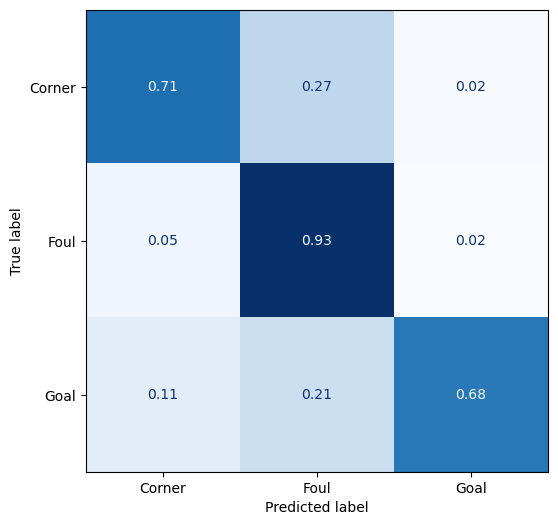

In [50]:
plot_confusion_matrix(predicted_labels_15,
                      encoded_dataset_15['test']['labels'],
                      ['Corner', 'Foul', 'Goal'],
                      filename='conf_matrix_BERT_LARGE_15.png')

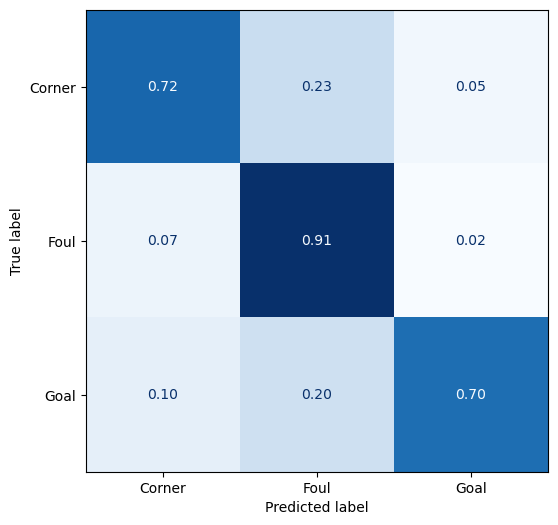

In [51]:
plot_confusion_matrix(predicted_labels_30,
                      encoded_dataset_30['test']['labels'],
                      ['Corner', 'Foul', 'Goal'],
                     filename='conf_matrix_BERT_LARGE_30.png')

In [41]:
# Plotting the confusion matrix
#sns.heatmap(conf_matrix, annot=True, fmt='g')
#plt.xlabel('Predicted labels')
#plt.ylabel('True labels')
#plt.show()

#print(labels_name[0],':', labels[0])
#print(labels_name[1],':', labels[1])
#print(labels_name[2],':', labels[2])

In [46]:
# Learning curve 
#training_losses = loss_metric._training_losses
#validation_losses = loss_metric._validation_losses

#epochs = range(1, len(validation_losses) + 1)

#plt.figure(figsize=(10, 6))
#plt.plot(epochs, training_losses, label='Training Loss')
#plt.plot(epochs, validation_losses, label='Validation Loss')
#plt.title('Learning Curve')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
#plt.show()